# Imports

In [3]:
import os
import numpy as np
import pandas as pd
from polars import read_csv as pl_read_csv
import polars as pl
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from tqdm import tqdm, trange
import matplotlib.lines as mlines
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

import scienceplots

plt.style.use(['science', 'no-latex'])
pd.options.mode.chained_assignment = None

In [4]:
def generate_stat(folder, eval_quantiles, agent_name, return_resutls=False):

    eval_df = pl_read_csv(folder, n_threads=8).to_pandas()
    eval_loop_df = eval_df[['episode', 'step_pnl', 'hed_cost']].groupby('episode').aggregate('sum')
    eval_loop_df.columns = ['episode_return', 'tc']
    
    gamma_exposure_df = eval_df[['episode', 'gamma_before_hedge', 'gamma_after_hedge']]
    gamma_exposure_df['gamma_hedged_amount'] = (gamma_exposure_df['gamma_before_hedge'] - gamma_exposure_df['gamma_after_hedge']) * np.sign(gamma_exposure_df['gamma_before_hedge'])
    gamma_exposure_df['gamma_before_hedge_level'] = gamma_exposure_df['gamma_before_hedge'].abs()
    gamma_exposure_df = gamma_exposure_df.groupby('episode').aggregate('sum')
    gamma_exposure = gamma_exposure_df['gamma_hedged_amount'] / gamma_exposure_df['gamma_before_hedge_level']
    
    vega_exposure_df = eval_df[['episode', 'vega_before_hedge', 'vega_after_hedge']]
    vega_exposure_df['vega_hedged_amount'] = (vega_exposure_df['vega_before_hedge'] - vega_exposure_df['vega_after_hedge']) * np.sign(vega_exposure_df['vega_before_hedge'])
    vega_exposure_df['vega_before_hedge_level'] = vega_exposure_df['vega_before_hedge'].abs()
    vega_exposure_df = vega_exposure_df.groupby('episode').aggregate('sum')
    vega_exposure = vega_exposure_df['vega_hedged_amount'] / vega_exposure_df['vega_before_hedge_level']

    # Calculate BCa Bootstrap Confidence Interval for 'episode_return'
    pnl_data = eval_loop_df['episode_return'].values
    pnl_std  = eval_loop_df['episode_return'].std()
    pnl_bootstrap = bs.bootstrap(pnl_data, stat_func=bs_stats.mean, alpha=0.05, num_iterations=10000, num_threads=16)
    pnl_mean = pnl_bootstrap.value
    pnl_half_width = (pnl_bootstrap.upper_bound - pnl_bootstrap.lower_bound) / 2

    # Calculate BCa Bootstrap Confidence Interval for 'tc'
    tc_data = eval_loop_df['tc'].values
    tc_bootstrap = bs.bootstrap( tc_data, stat_func=bs_stats.mean, alpha=0.05, num_iterations=10000, num_threads=16 )
    tc_mean = tc_bootstrap.value
    tc_half_width = (tc_bootstrap.upper_bound - tc_bootstrap.lower_bound) / 2

    # Returning statistics:
    mean_std = eval_loop_df['episode_return'].mean() - 1.645 * eval_loop_df['episode_return'].std()
    gamma_ratio = gamma_exposure.mean()
    vega_ratio = vega_exposure.mean()

    stats_str = (
        f"{agent_name:<20} pnl mean: {pnl_mean:<6.2f}(±{pnl_half_width:<4.2f}) | "
        f"std: {pnl_std:<10.5f} | "
        f"Mean-SD: {mean_std:<6.2f} | "
        f"gamma-ratio: {gamma_ratio:5.2f} ({gamma_exposure.quantile(0.10):5.2f}/{gamma_exposure.quantile(0.90):5.2f}) | "
        f"vega-ratio: {vega_ratio:5.2f} ({vega_exposure.quantile(0.10):5.2f}/{vega_exposure.quantile(0.90):5.2f})"
    )
    
    for q in eval_quantiles:
        stats_str += f"| var{100 * q:.0f}: {eval_loop_df['episode_return'].quantile(1 - q):8.2f} "
    
    for q in eval_quantiles:
        cvar_value = eval_loop_df.loc[
            eval_loop_df['episode_return'] <= eval_loop_df['episode_return'].quantile(1 - q),
            'episode_return'
        ].mean()
        stats_str += f"| cvar{100 * q:.0f}: {cvar_value:8.2f} "
    
    stats_str += f"| E[TC]: {tc_mean:<6.2f}(±{tc_half_width:<4.2f})"
    
    print(stats_str)
    if return_resutls:
        # pnl mean	std	Mean-SD	gamma-ratio	vega-ratio	var95	cvar95	E[TC]
        var95  = eval_loop_df['episode_return'].quantile(1 - .95)
        cvar95 = eval_loop_df.loc[eval_loop_df['episode_return'] <= var95, 'episode_return'].mean()
        return pnl_mean , pnl_std , mean_std , gamma_ratio , vega_ratio , var95 , cvar95 , tc_mean

# Define quantiles for evaluation
eval_quantiles = [0.95]

---

# Mean Std 0.5%

Heston Mean Std 0.5%:4 pnl mean: -4.12 (±0.29) | std: 13.61005   | Mean-SD: -26.51 | gamma-ratio:  0.40 ( 0.03/ 0.75) | vega-ratio:  0.30 ( 0.14/ 0.47)| var95:   -26.10 | cvar95:   -35.93 | E[TC]: -4.12 (±0.02)
Heston Mean Std 0.5%:23 pnl mean: -4.41 (±0.30) | std: 13.54756   | Mean-SD: -26.70 | gamma-ratio:  0.38 ( 0.01/ 0.77) | vega-ratio:  0.35 ( 0.17/ 0.53)| var95:   -26.19 | cvar95:   -37.05 | E[TC]: -4.35 (±0.02)
Heston Mean Std 0.5%:17 pnl mean: -4.32 (±0.30) | std: 13.74489   | Mean-SD: -26.93 | gamma-ratio:  0.42 ( 0.04/ 0.77) | vega-ratio:  0.33 ( 0.15/ 0.52)| var95:   -26.27 | cvar95:   -36.43 | E[TC]: -4.40 (±0.02)
Heston Mean Std 0.5%:30 pnl mean: -4.23 (±0.30) | std: 13.63946   | Mean-SD: -26.66 | gamma-ratio:  0.38 ( 0.03/ 0.73) | vega-ratio:  0.33 ( 0.15/ 0.50)| var95:   -26.34 | cvar95:   -37.03 | E[TC]: -4.17 (±0.02)
Heston Mean Std 0.5%:5 pnl mean: -4.28 (±0.30) | std: 13.76501   | Mean-SD: -26.93 | gamma-ratio:  0.47 ( 0.05/ 0.84) | vega-ratio:  0.31 ( 0.13/ 0.52)| 

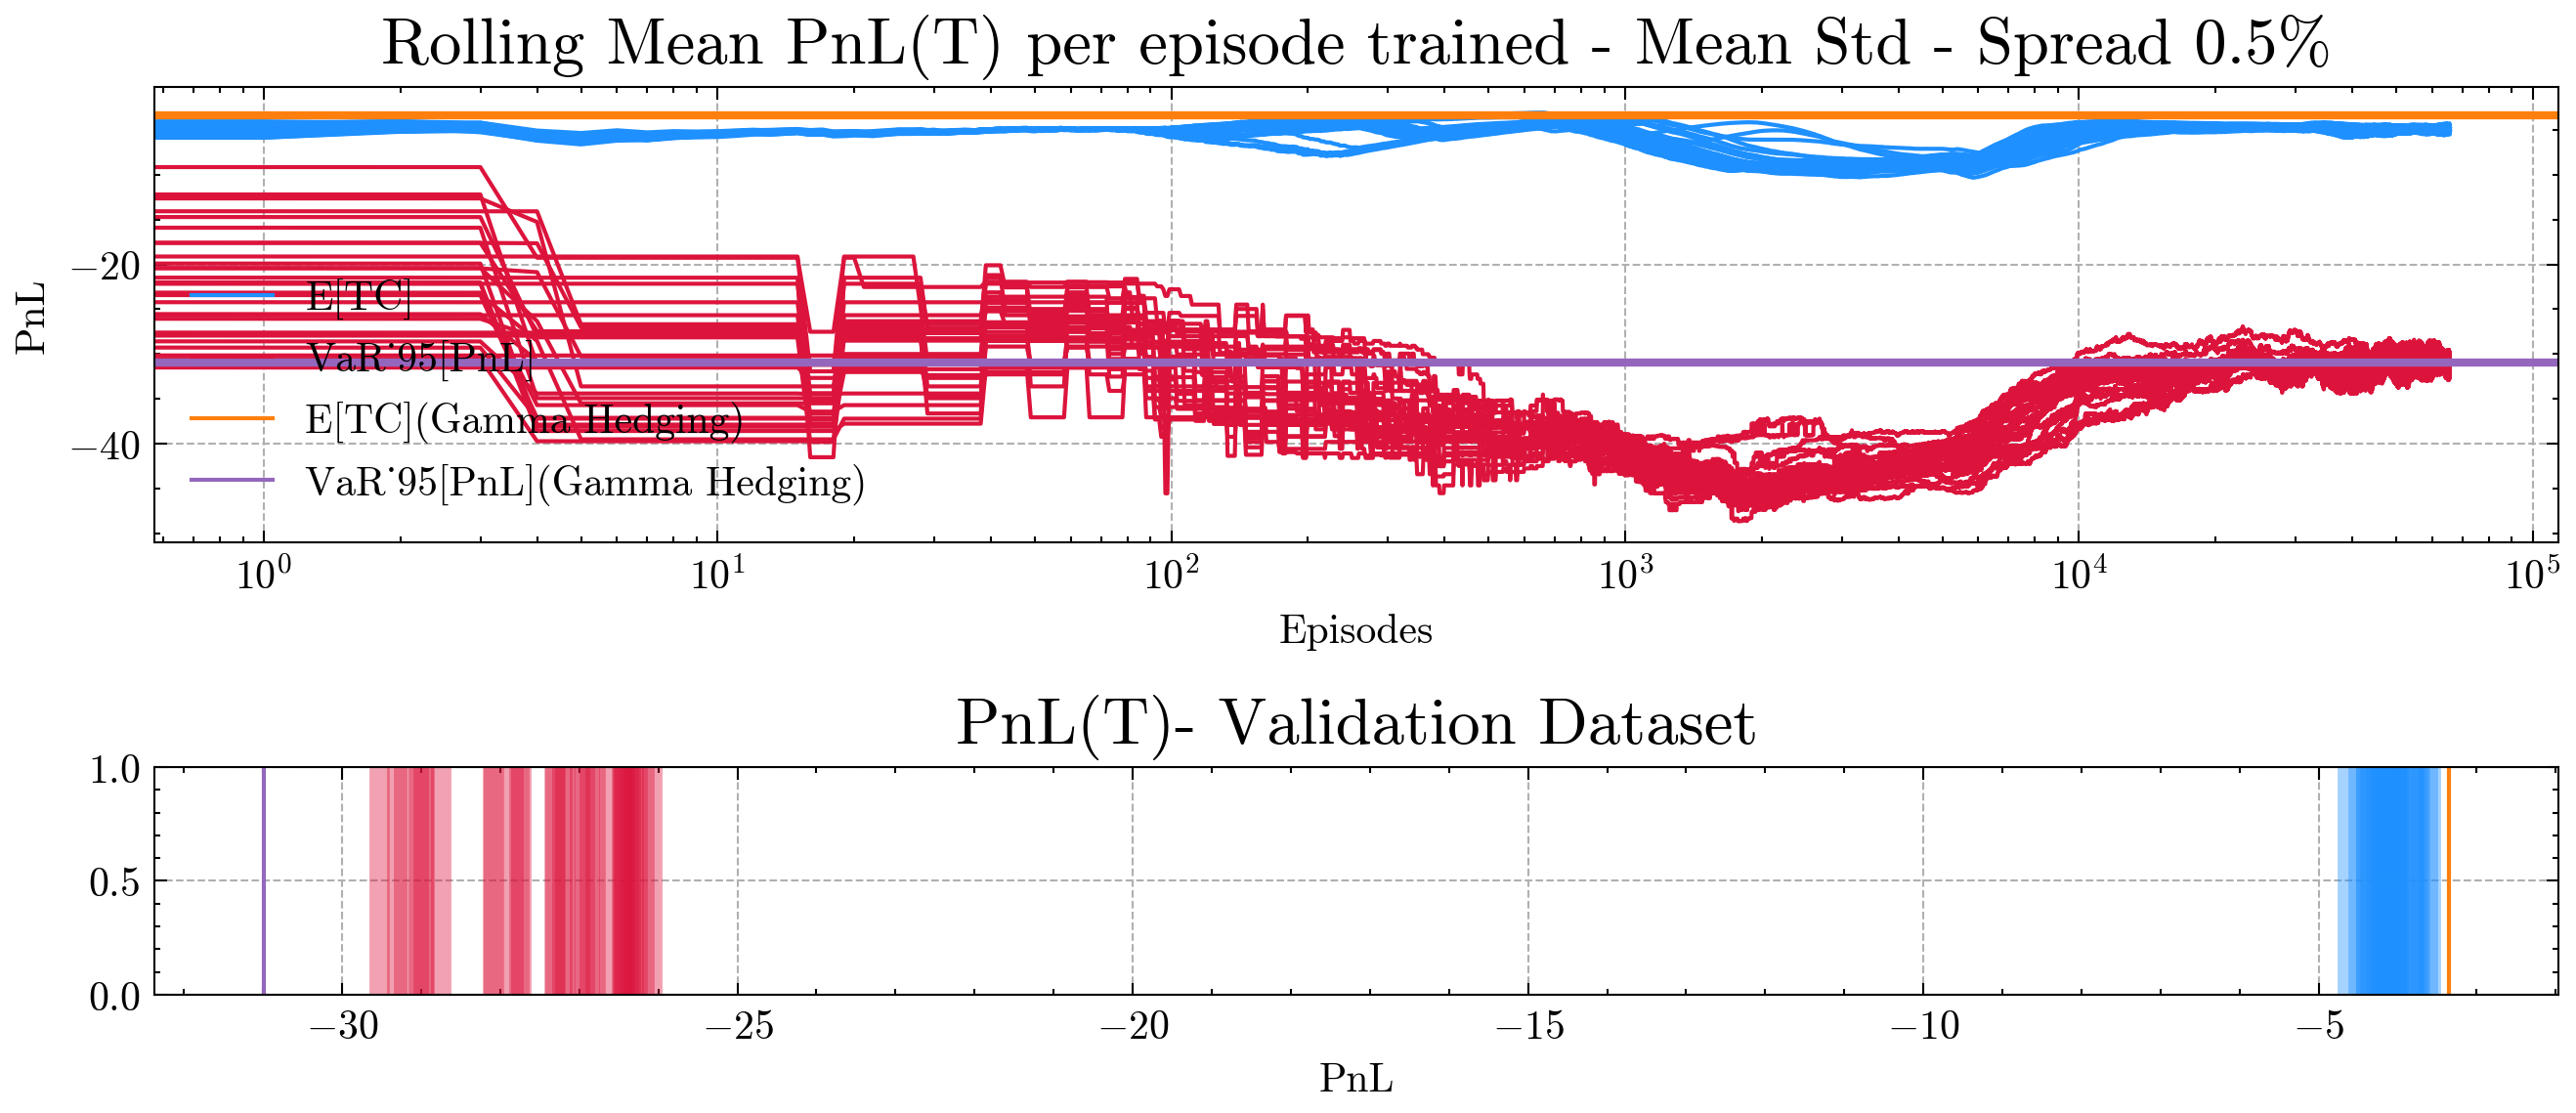

In [25]:
base_path = 'logs/(EXP 4) Heston Experiments/spread_05/Heston_Mean_Std_Batch/'
N_E = 31
batch_template_train = (
    "Heston_Mean_Std_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_Mean_Std_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_Mean_Std_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

# plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(9, 4), dpi=300, gridspec_kw={'height_ratios': [2, 1]})

for i in [4, 23, 17, 30, 5, 2, 9, 15, 11, 25, 24, 27, 20, 16, 14, 3, 6, 1, 26, 28, 19, 18, 0, 10, 13, 8, 12, 21, 22, 29, 7]:
    df = (
        pl_read_csv(batch_folders_train[i])#, n_threads=1)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_samples=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_samples=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    df = (
        pl_read_csv(batch_folders_eval[i])#, n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Mean Std 0.5%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - Mean Std - Spread 0.5%", fontsize=16)
ax1.set_xlabel("Episodes", )
ax1.set_ylabel("PnL", )
ax1.set_xscale('log')
ax1.grid(True, linestyle='--')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", fontsize=16)
ax2.set_xlabel("PnL", )
ax2.grid(True, linestyle='--')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 4) Heston Experiments/spread_05/Heston_Gamma_05/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 4) Heston Experiments/spread_05/Heston_Delta_05/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Delta 0.5%')
generate_stat('logs/(EXP 4) Heston Experiments/spread_05/Heston_Gamma_05/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 0.5%')
generate_stat('logs/(EXP 4) Heston Experiments/spread_05/Heston_Vega_05/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Vega 0.5%')

plt.tight_layout()
plt.show()


# VaR 0.5%

Heston VaR 0.5%:2    pnl mean: -3.58 (±0.29) | std: 13.65500   | Mean-SD: -26.04 | gamma-ratio:  0.46 ( 0.09/ 0.75) | vega-ratio:  0.25 ( 0.12/ 0.40)| var95:   -25.57 | cvar95:   -35.15 | E[TC]: -3.57 (±0.02)
Heston VaR 0.5%:24   pnl mean: -3.91 (±0.30) | std: 13.62602   | Mean-SD: -26.32 | gamma-ratio:  0.40 ( 0.05/ 0.72) | vega-ratio:  0.28 ( 0.13/ 0.45)| var95:   -25.79 | cvar95:   -35.71 | E[TC]: -3.82 (±0.02)
Heston VaR 0.5%:26   pnl mean: -4.04 (±0.30) | std: 14.05164   | Mean-SD: -27.16 | gamma-ratio:  0.44 ( 0.05/ 0.79) | vega-ratio:  0.29 ( 0.13/ 0.46)| var95:   -26.81 | cvar95:   -37.72 | E[TC]: -3.91 (±0.02)
Heston VaR 0.5%:6    pnl mean: -3.99 (±0.31) | std: 14.32878   | Mean-SD: -27.56 | gamma-ratio:  0.45 ( 0.10/ 0.75) | vega-ratio:  0.27 ( 0.10/ 0.45)| var95:   -26.86 | cvar95:   -38.70 | E[TC]: -3.98 (±0.03)
Heston VaR 0.5%:36   pnl mean: -3.94 (±0.30) | std: 13.93104   | Mean-SD: -26.85 | gamma-ratio:  0.44 ( 0.11/ 0.70) | vega-ratio:  0.26 ( 0.10/ 0.43)| var95:   -26.

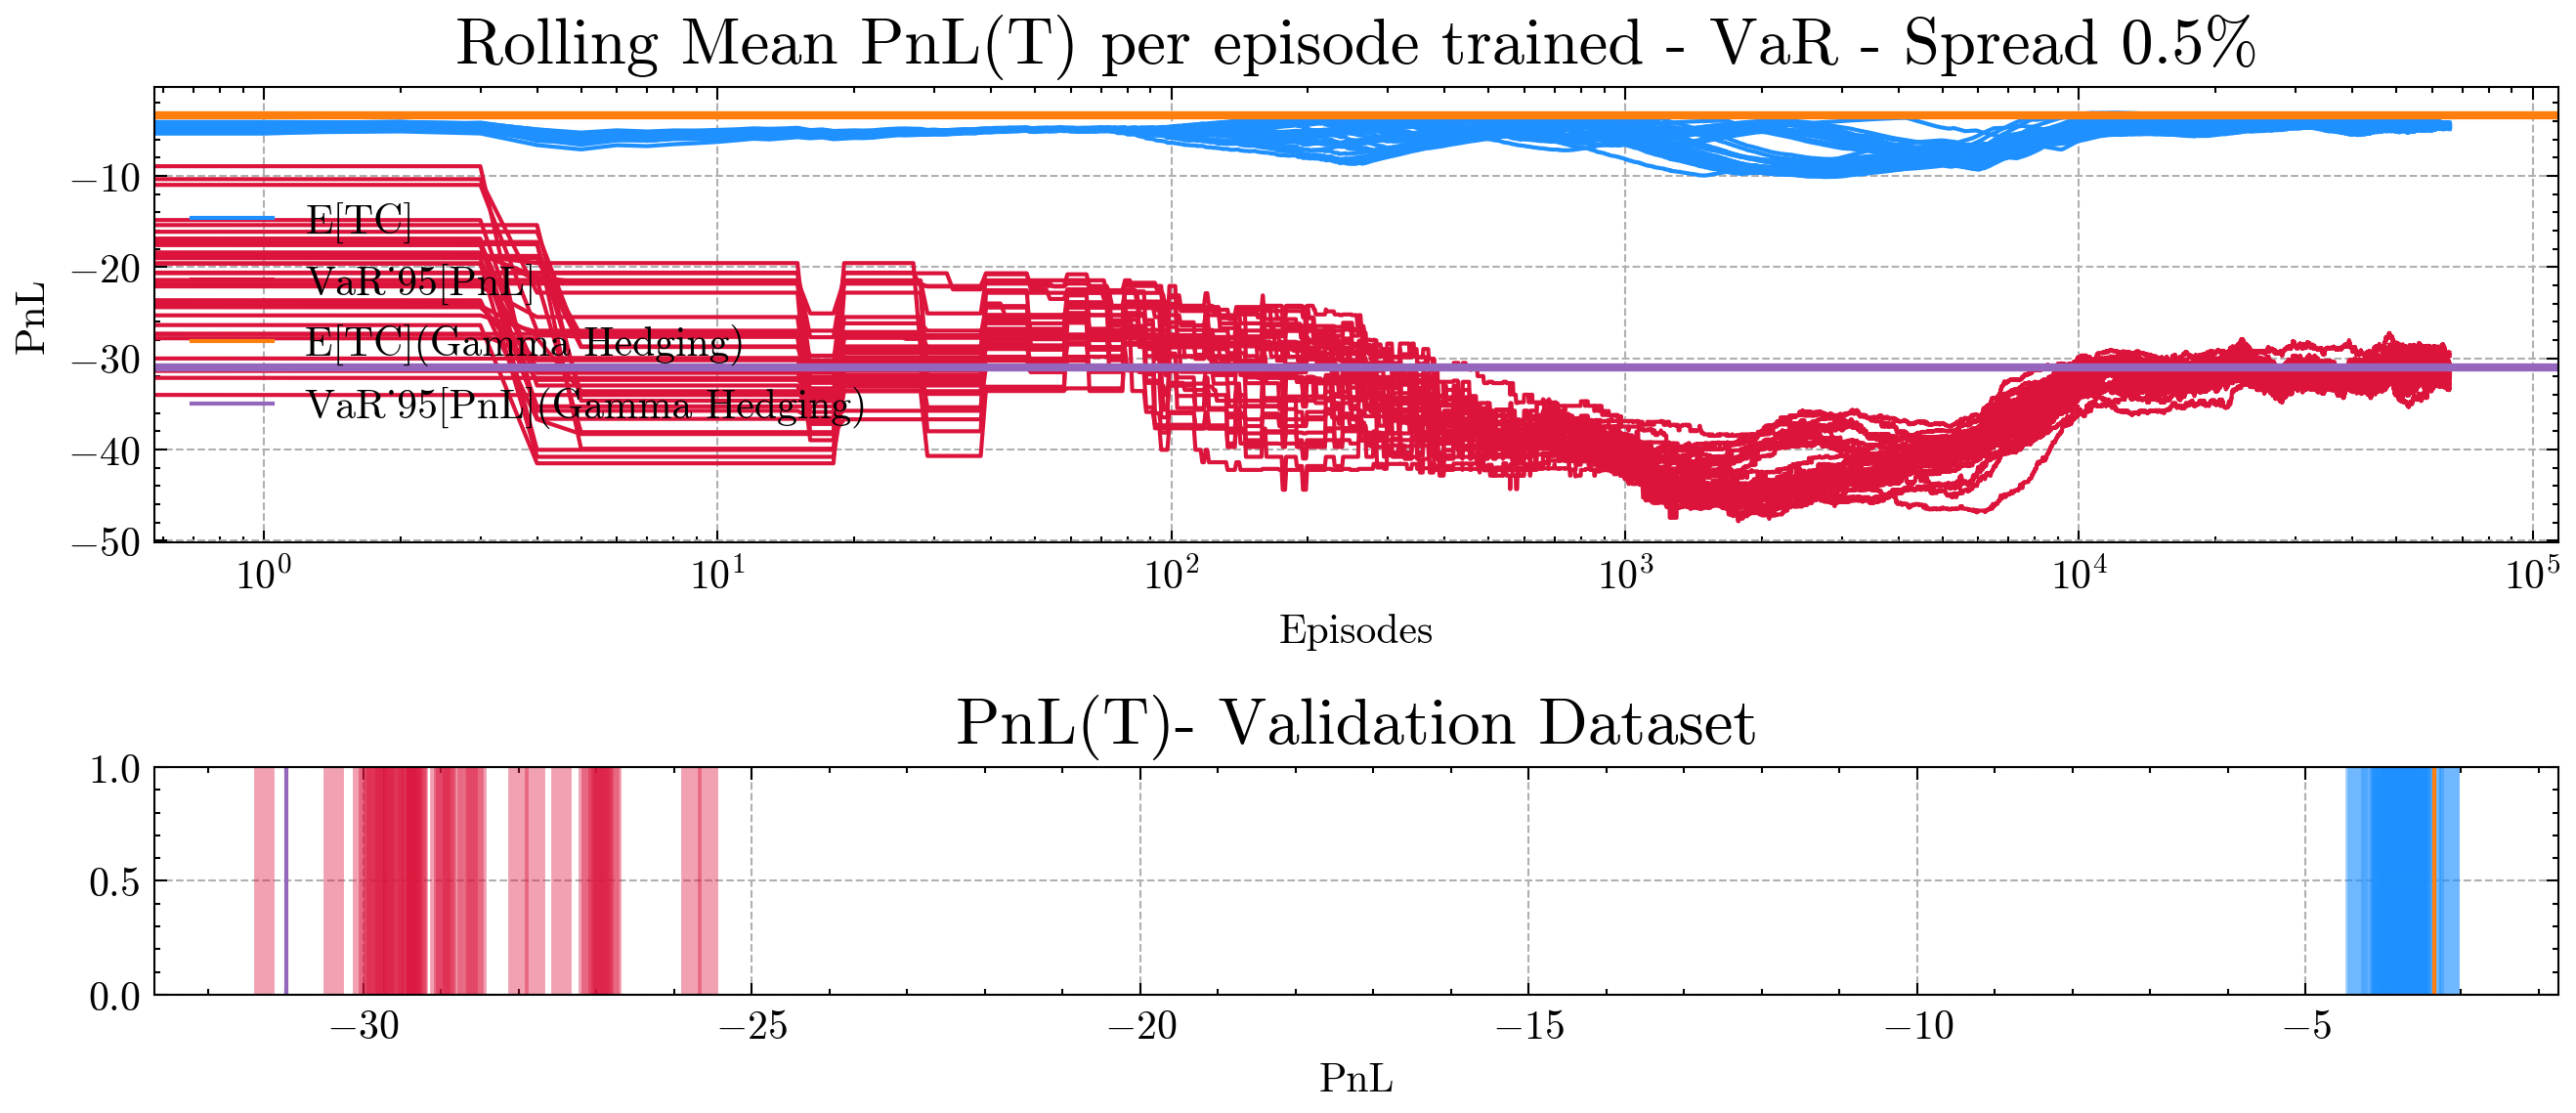

In [26]:
base_path = 'logs/(EXP 4) Heston Experiments/spread_05/Heston_VaR_Batch/'
N_E = 37
batch_template_train = (
    "Heston_VaR_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_VaR_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_VaR_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

# plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(9, 4), dpi=300, gridspec_kw={'height_ratios': [2, 1]})

for i in [2, 24, 26, 6, 36, 10, 33, 4, 21, 20, 27, 32, 29, 8, 7, 17, 25, 16, 14, 3, 31, 19, 28, 11, 5, 30, 1, 15, 9, 0, 18, 22, 23, 12, 35, 34, 13]:
    df = (
        pl_read_csv(batch_folders_train[i])#, n_threads=1)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_samples=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_samples=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    df = (
        pl_read_csv(batch_folders_eval[i])#, n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston VaR 0.5%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - VaR - Spread 0.5%", fontsize=16)
ax1.set_xlabel("Episodes", )
ax1.set_ylabel("PnL", )
ax1.set_xscale('log')
ax1.grid(True, linestyle='--')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", fontsize=16)
ax2.set_xlabel("PnL", )
ax2.grid(True, linestyle='--')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 4) Heston Experiments/spread_05/Heston_Gamma_05/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 4) Heston Experiments/spread_05/Heston_Delta_05/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Delta 0.5%')
generate_stat('logs/(EXP 4) Heston Experiments/spread_05/Heston_Gamma_05/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 0.5%')
generate_stat('logs/(EXP 4) Heston Experiments/spread_05/Heston_Vega_05/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Vega 0.5%')

plt.tight_layout()
plt.show()


# CVaR 0.5%

Heston CVaR 0.5%:8   pnl mean: -3.82 (±0.29) | std: 13.51093   | Mean-SD: -26.05 | gamma-ratio:  0.45 ( 0.07/ 0.76) | vega-ratio:  0.26 ( 0.12/ 0.43)| var95:   -25.62 | cvar95:   -35.41 | E[TC]: -3.72 (±0.02)
Heston CVaR 0.5%:14  pnl mean: -3.73 (±0.30) | std: 14.03272   | Mean-SD: -26.81 | gamma-ratio:  0.47 ( 0.10/ 0.75) | vega-ratio:  0.26 ( 0.11/ 0.44)| var95:   -25.68 | cvar95:   -35.76 | E[TC]: -3.74 (±0.02)
Heston CVaR 0.5%:10  pnl mean: -3.87 (±0.31) | std: 13.97801   | Mean-SD: -26.86 | gamma-ratio:  0.45 ( 0.04/ 0.80) | vega-ratio:  0.27 ( 0.13/ 0.43)| var95:   -26.09 | cvar95:   -36.25 | E[TC]: -3.73 (±0.02)
Heston CVaR 0.5%:30  pnl mean: -4.10 (±0.30) | std: 13.55588   | Mean-SD: -26.40 | gamma-ratio:  0.40 ( 0.06/ 0.71) | vega-ratio:  0.30 ( 0.13/ 0.48)| var95:   -26.25 | cvar95:   -36.14 | E[TC]: -4.08 (±0.02)
Heston CVaR 0.5%:20  pnl mean: -3.93 (±0.30) | std: 13.93444   | Mean-SD: -26.86 | gamma-ratio:  0.43 ( 0.07/ 0.75) | vega-ratio:  0.30 ( 0.12/ 0.49)| var95:   -26.

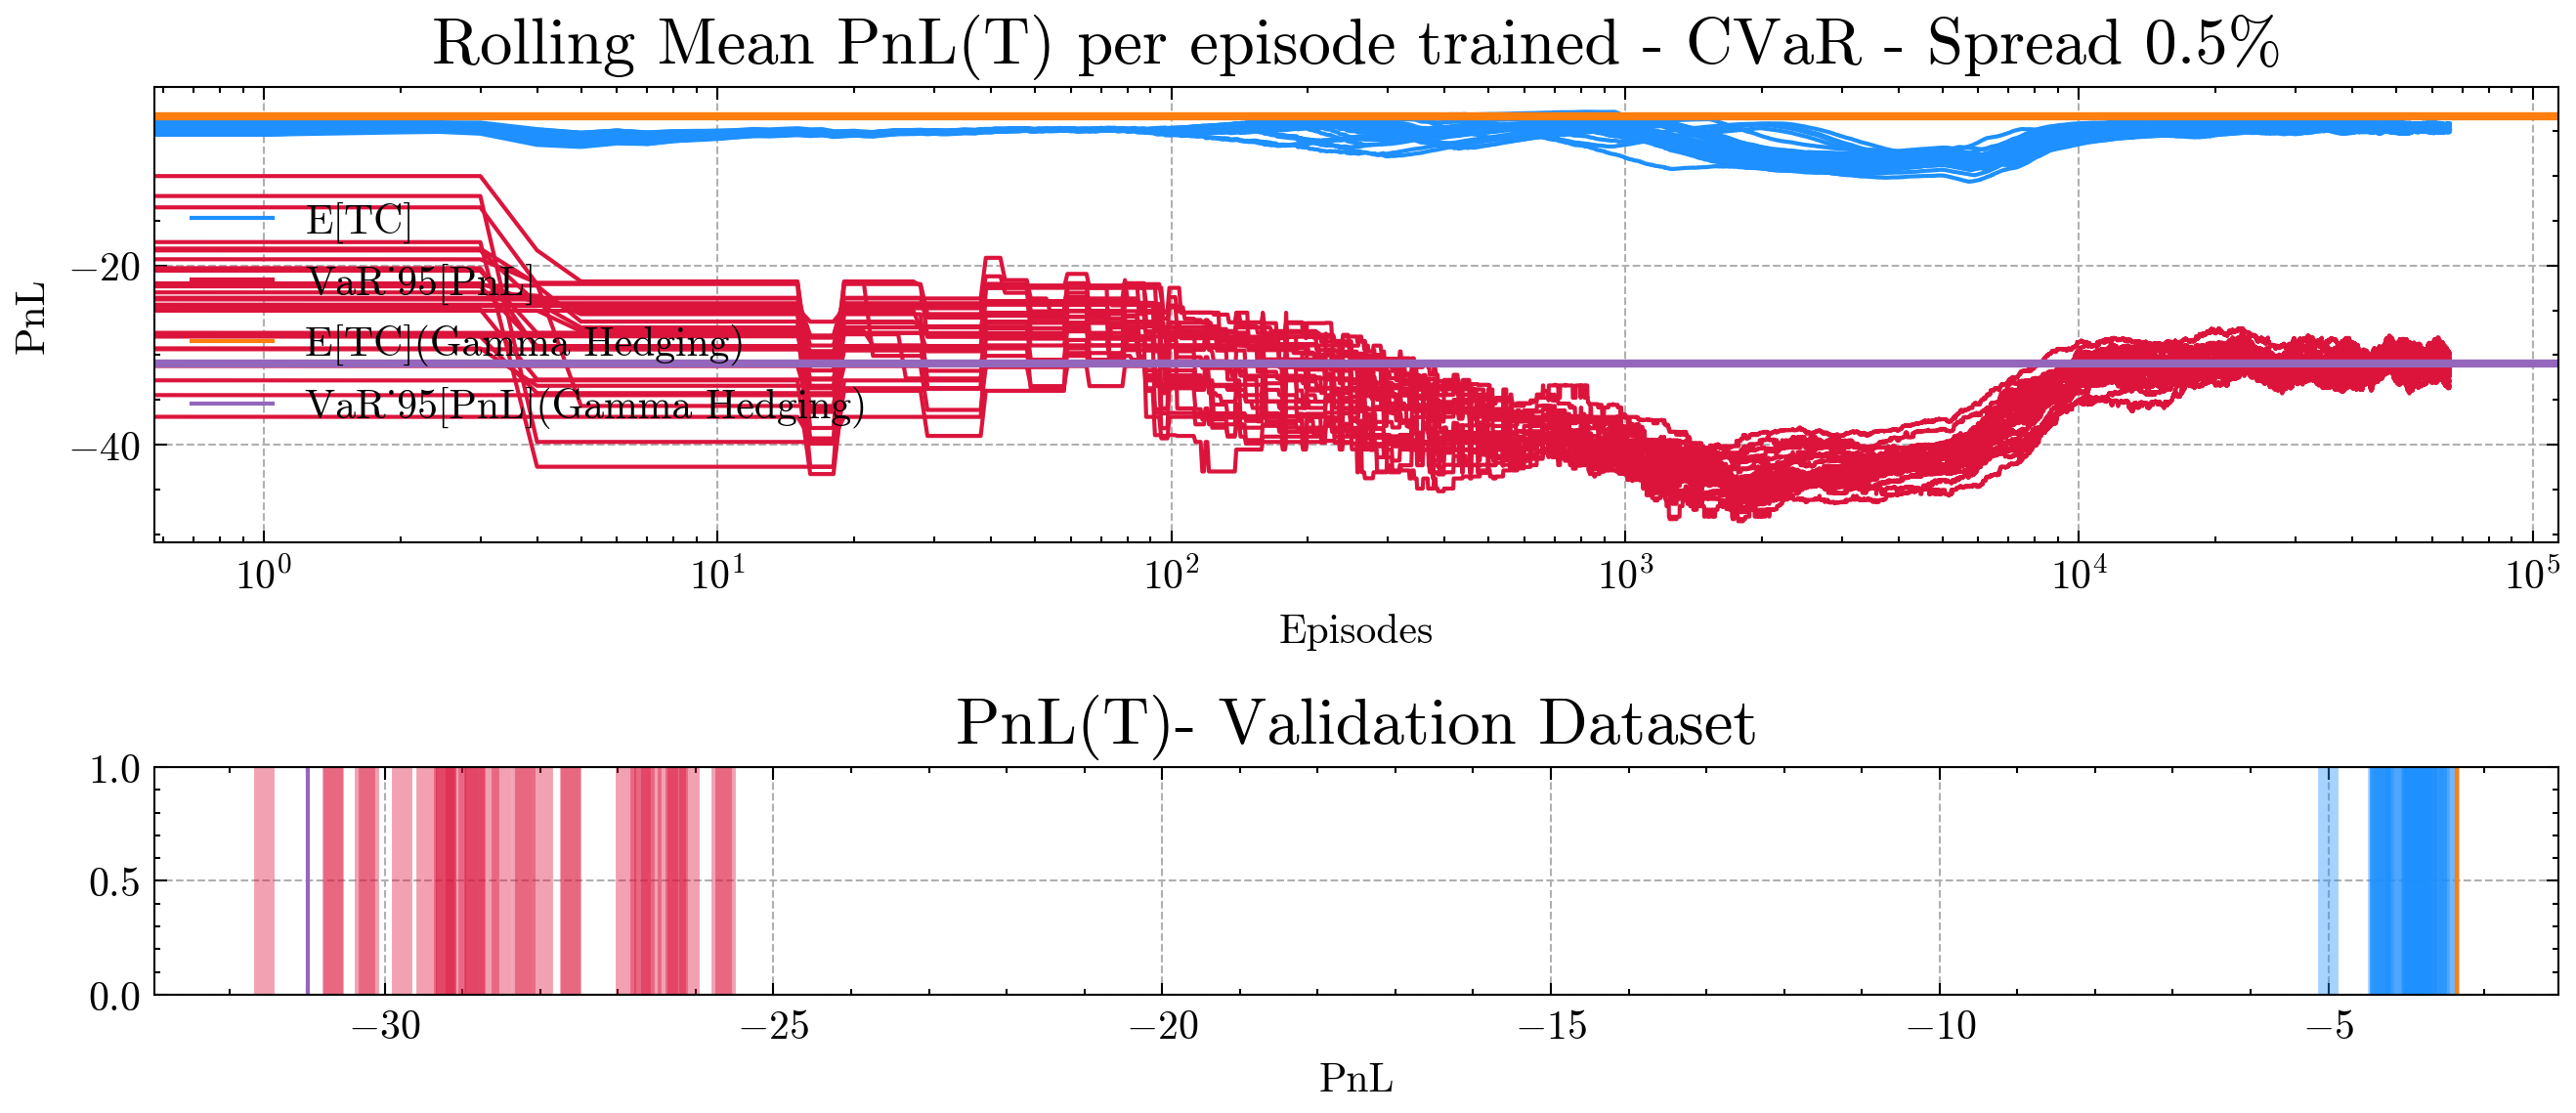

In [27]:
base_path = 'logs/(EXP 4) Heston Experiments/spread_05/Heston_CVaR_Batch/'
N_E = 31
batch_template_train = (
    "Heston_CVaR_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_CVaR_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_CVaR_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

# plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(9, 4), dpi=300, gridspec_kw={'height_ratios': [2, 1]})

for i in [8, 14, 10, 30, 20, 12, 1, 2, 23, 26, 0, 24, 5, 9, 13, 27, 29, 11, 16, 22, 6, 18, 21, 17, 3, 15, 7, 28, 19, 4, 25]:
    df = (
        pl_read_csv(batch_folders_train[i])#, n_threads=1)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_samples=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_samples=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    df = (
        pl_read_csv(batch_folders_eval[i])#, n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston CVaR 0.5%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - CVaR - Spread 0.5%", fontsize=16)
ax1.set_xlabel("Episodes", )
ax1.set_ylabel("PnL", )
ax1.set_xscale('log')
ax1.grid(True, linestyle='--')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", fontsize=16)
ax2.set_xlabel("PnL", )
ax2.grid(True, linestyle='--')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 4) Heston Experiments/spread_05/Heston_Gamma_05/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 4) Heston Experiments/spread_05/Heston_Delta_05/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Delta 0.5%:{i}')
generate_stat('logs/(EXP 4) Heston Experiments/spread_05/Heston_Gamma_05/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 0.5%:{i}')
generate_stat('logs/(EXP 4) Heston Experiments/spread_05/Heston_Vega_05/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Vega 0.5%:{i}')

plt.tight_layout()
plt.show()


---
# Mean-Std 1%

Heston Mean Std 1%:17 pnl mean: -5.83 (±0.31) | std: 14.41559   | Mean-SD: -29.55 | gamma-ratio:  0.32 ( 0.05/ 0.52) | vega-ratio:  0.19 ( 0.10/ 0.29)| var95:   -29.17 | cvar95:   -39.92 | E[TC]: -5.76 (±0.04)


Heston Mean Std 1%:19 pnl mean: -6.69 (±0.32) | std: 14.38335   | Mean-SD: -30.35 | gamma-ratio:  0.40 ( 0.04/ 0.68) | vega-ratio:  0.24 ( 0.12/ 0.38)| var95:   -29.68 | cvar95:   -39.98 | E[TC]: -6.61 (±0.03)
Heston Mean Std 1%:20 pnl mean: -7.59 (±0.30) | std: 13.69400   | Mean-SD: -30.12 | gamma-ratio:  0.41 ( 0.05/ 0.75) | vega-ratio:  0.28 ( 0.13/ 0.44)| var95:   -29.90 | cvar95:   -39.68 | E[TC]: -7.67 (±0.04)
Heston Mean Std 1%:11 pnl mean: -6.63 (±0.31) | std: 14.32558   | Mean-SD: -30.19 | gamma-ratio:  0.33 ( 0.01/ 0.62) | vega-ratio:  0.26 ( 0.12/ 0.38)| var95:   -29.96 | cvar95:   -40.57 | E[TC]: -6.47 (±0.03)
Heston Mean Std 1%:4 pnl mean: -6.87 (±0.31) | std: 14.28852   | Mean-SD: -30.38 | gamma-ratio:  0.35 ( 0.05/ 0.62) | vega-ratio:  0.25 ( 0.10/ 0.40)| var95:   -30.27 | cvar95:   -40.42 | E[TC]: -6.76 (±0.04)
Heston Mean Std 1%:16 pnl mean: -7.66 (±0.30) | std: 13.75710   | Mean-SD: -30.29 | gamma-ratio:  0.45 ( 0.06/ 0.76) | vega-ratio:  0.26 ( 0.12/ 0.41)| var95:   

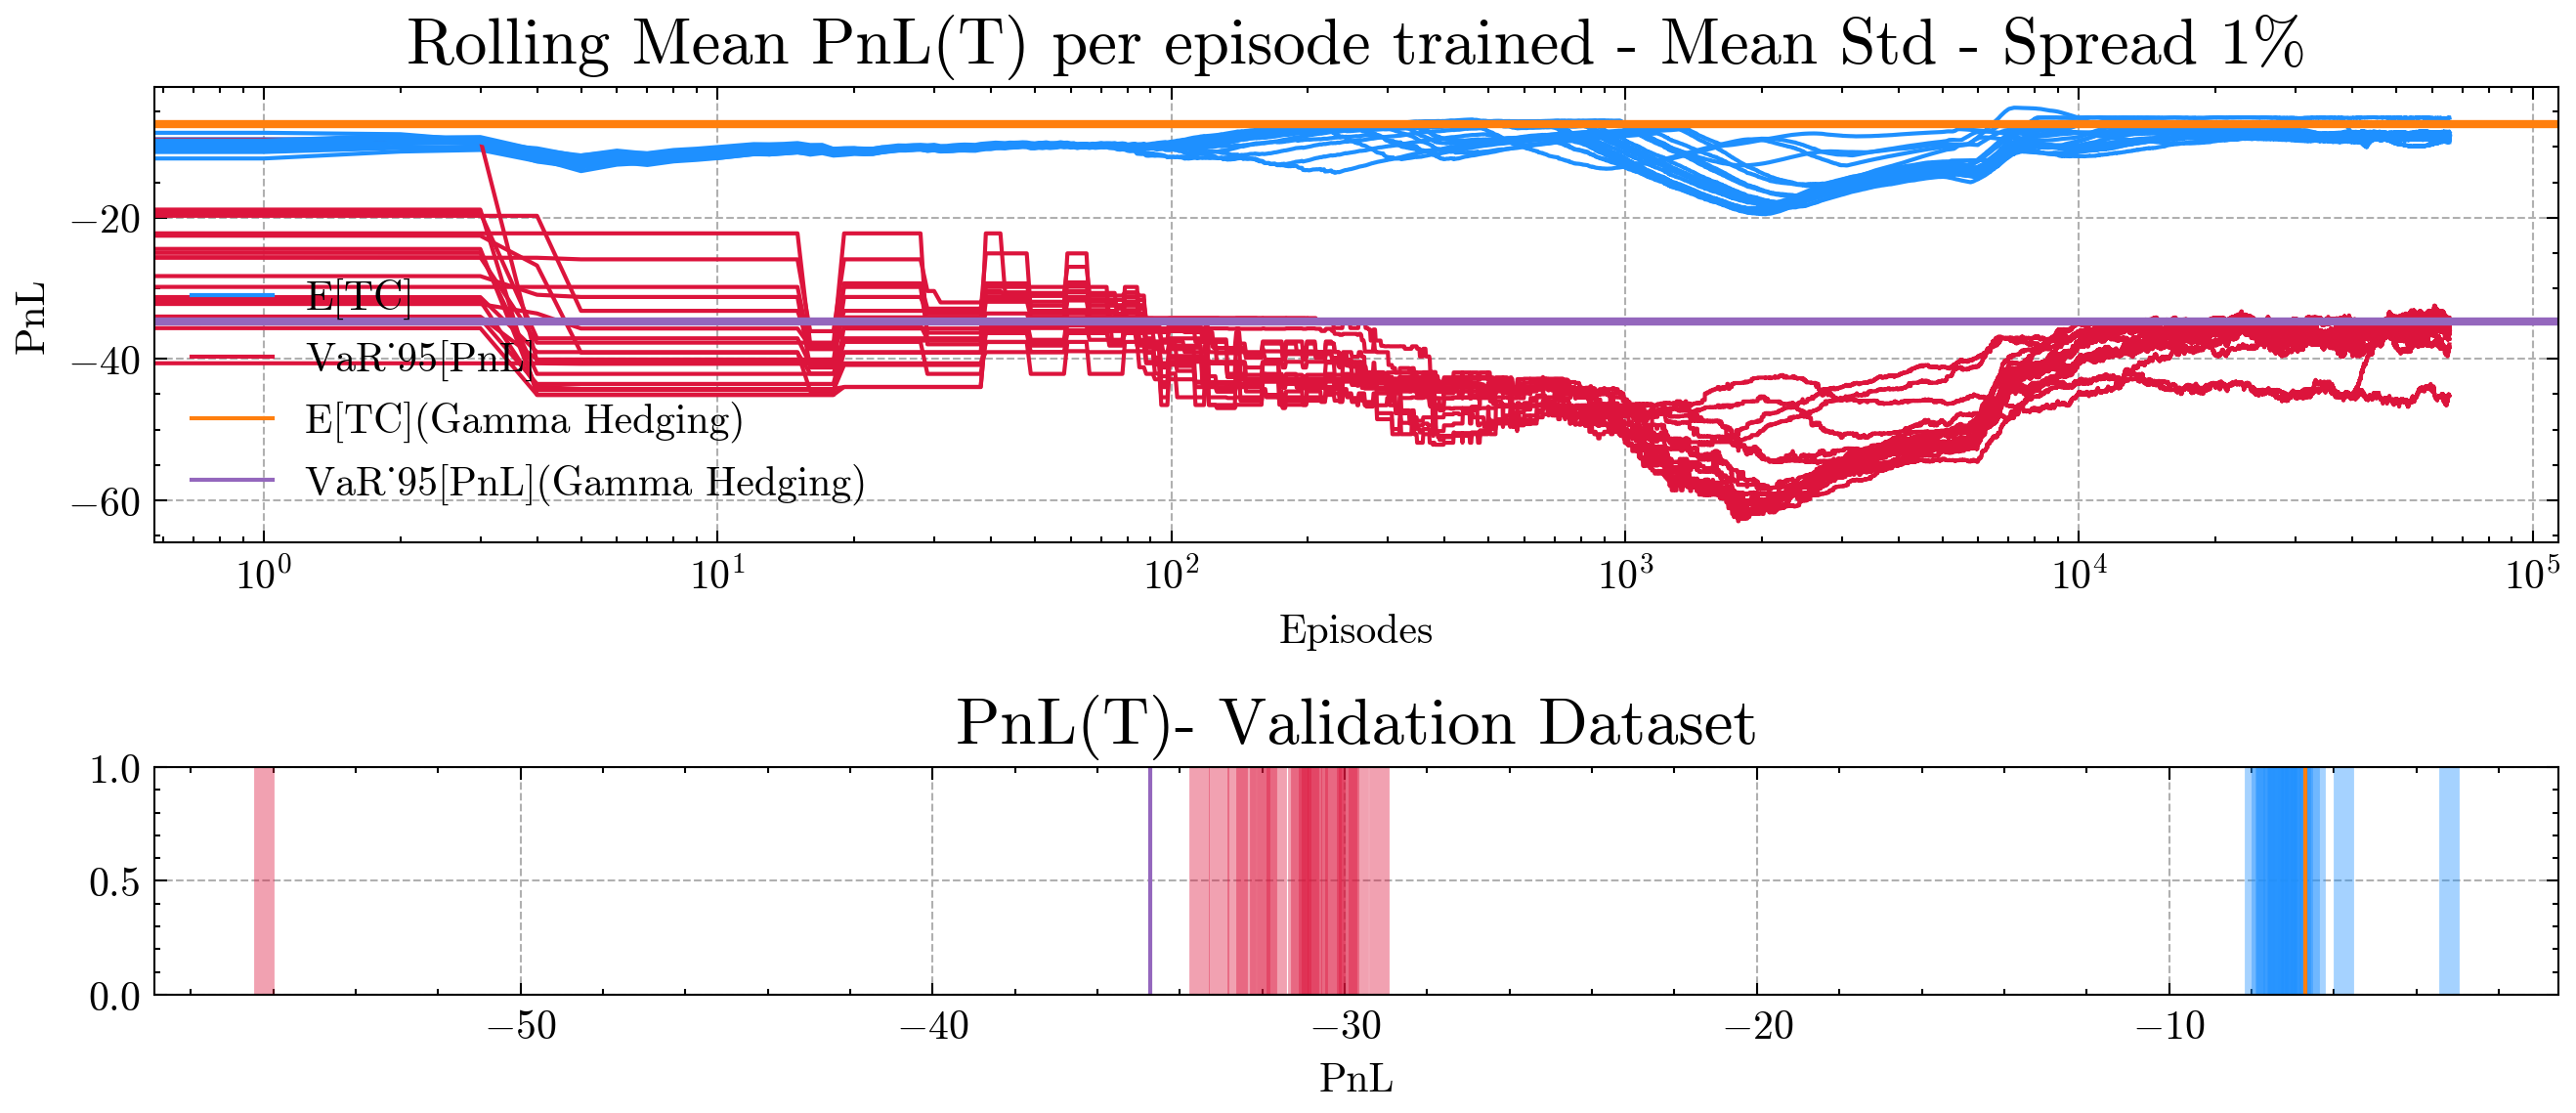

In [28]:
base_path = 'logs/(EXP 4) Heston Experiments/spread_1/Heston_Mean_Std_Batch/'
N_E = 21
batch_template_train = (
    "Heston_Mean_Std_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_Mean_Std_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_Mean_Std_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(9, 4), dpi=300, gridspec_kw={'height_ratios': [2, 1]})

for i in [17, 19, 20, 11, 4, 16, 2, 14, 15, 12, 18, 8, 9, 7, 13, 5, 3, 6, 10]:
    df = (
        pl_read_csv(batch_folders_train[i])#, n_threads=1)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_samples=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_samples=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    df = (
        pl_read_csv(batch_folders_eval[i])#, n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Mean Std 1%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - Mean Std - Spread 1%", fontsize=16)
ax1.set_xlabel("Episodes", )
ax1.set_ylabel("PnL", )
ax1.set_xscale('log')
ax1.grid(True, linestyle='--')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", fontsize=16)
ax2.set_xlabel("PnL", )
ax2.grid(True, linestyle='--')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 4) Heston Experiments/spread_1/Heston_Gamma_1/greekhedge_stochastic_process=Heston_spread=0.01_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 4) Heston Experiments/spread_1/Heston_Delta_1/greekhedge_stochastic_process=Heston_spread=0.01_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Delta 1%')
generate_stat('logs/(EXP 4) Heston Experiments/spread_1/Heston_Gamma_1/greekhedge_stochastic_process=Heston_spread=0.01_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 1%')
generate_stat('logs/(EXP 4) Heston Experiments/spread_1/Heston_Vega_1/greekhedge_stochastic_process=Heston_spread=0.01_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Vega 1%')

plt.tight_layout()
plt.show()

---
# VaR 1%

Heston VaR 1%:8      pnl mean: -5.82 (±0.31) | std: 14.25701   | Mean-SD: -29.27 | gamma-ratio:  0.36 ( 0.05/ 0.61) | vega-ratio:  0.20 ( 0.11/ 0.28)| var95:   -29.00 | cvar95:   -38.92 | E[TC]: -5.87 (±0.04)
Heston VaR 1%:7      pnl mean: -5.46 (±0.32) | std: 14.90152   | Mean-SD: -29.97 | gamma-ratio:  0.30 ( 0.03/ 0.50) | vega-ratio:  0.20 ( 0.11/ 0.30)| var95:   -29.46 | cvar95:   -39.83 | E[TC]: -5.51 (±0.04)
Heston VaR 1%:13     pnl mean: -6.43 (±0.31) | std: 14.34150   | Mean-SD: -30.02 | gamma-ratio:  0.36 ( 0.08/ 0.58) | vega-ratio:  0.20 ( 0.09/ 0.32)| var95:   -29.95 | cvar95:   -39.71 | E[TC]: -6.43 (±0.04)
Heston VaR 1%:0      pnl mean: -6.95 (±0.31) | std: 14.45380   | Mean-SD: -30.72 | gamma-ratio:  0.45 ( 0.08/ 0.73) | vega-ratio:  0.24 ( 0.11/ 0.38)| var95:   -30.03 | cvar95:   -40.26 | E[TC]: -6.93 (±0.04)
Heston VaR 1%:9      pnl mean: -7.24 (±0.31) | std: 14.28352   | Mean-SD: -30.74 | gamma-ratio:  0.42 ( 0.10/ 0.72) | vega-ratio:  0.26 ( 0.11/ 0.44)| var95:   -30.

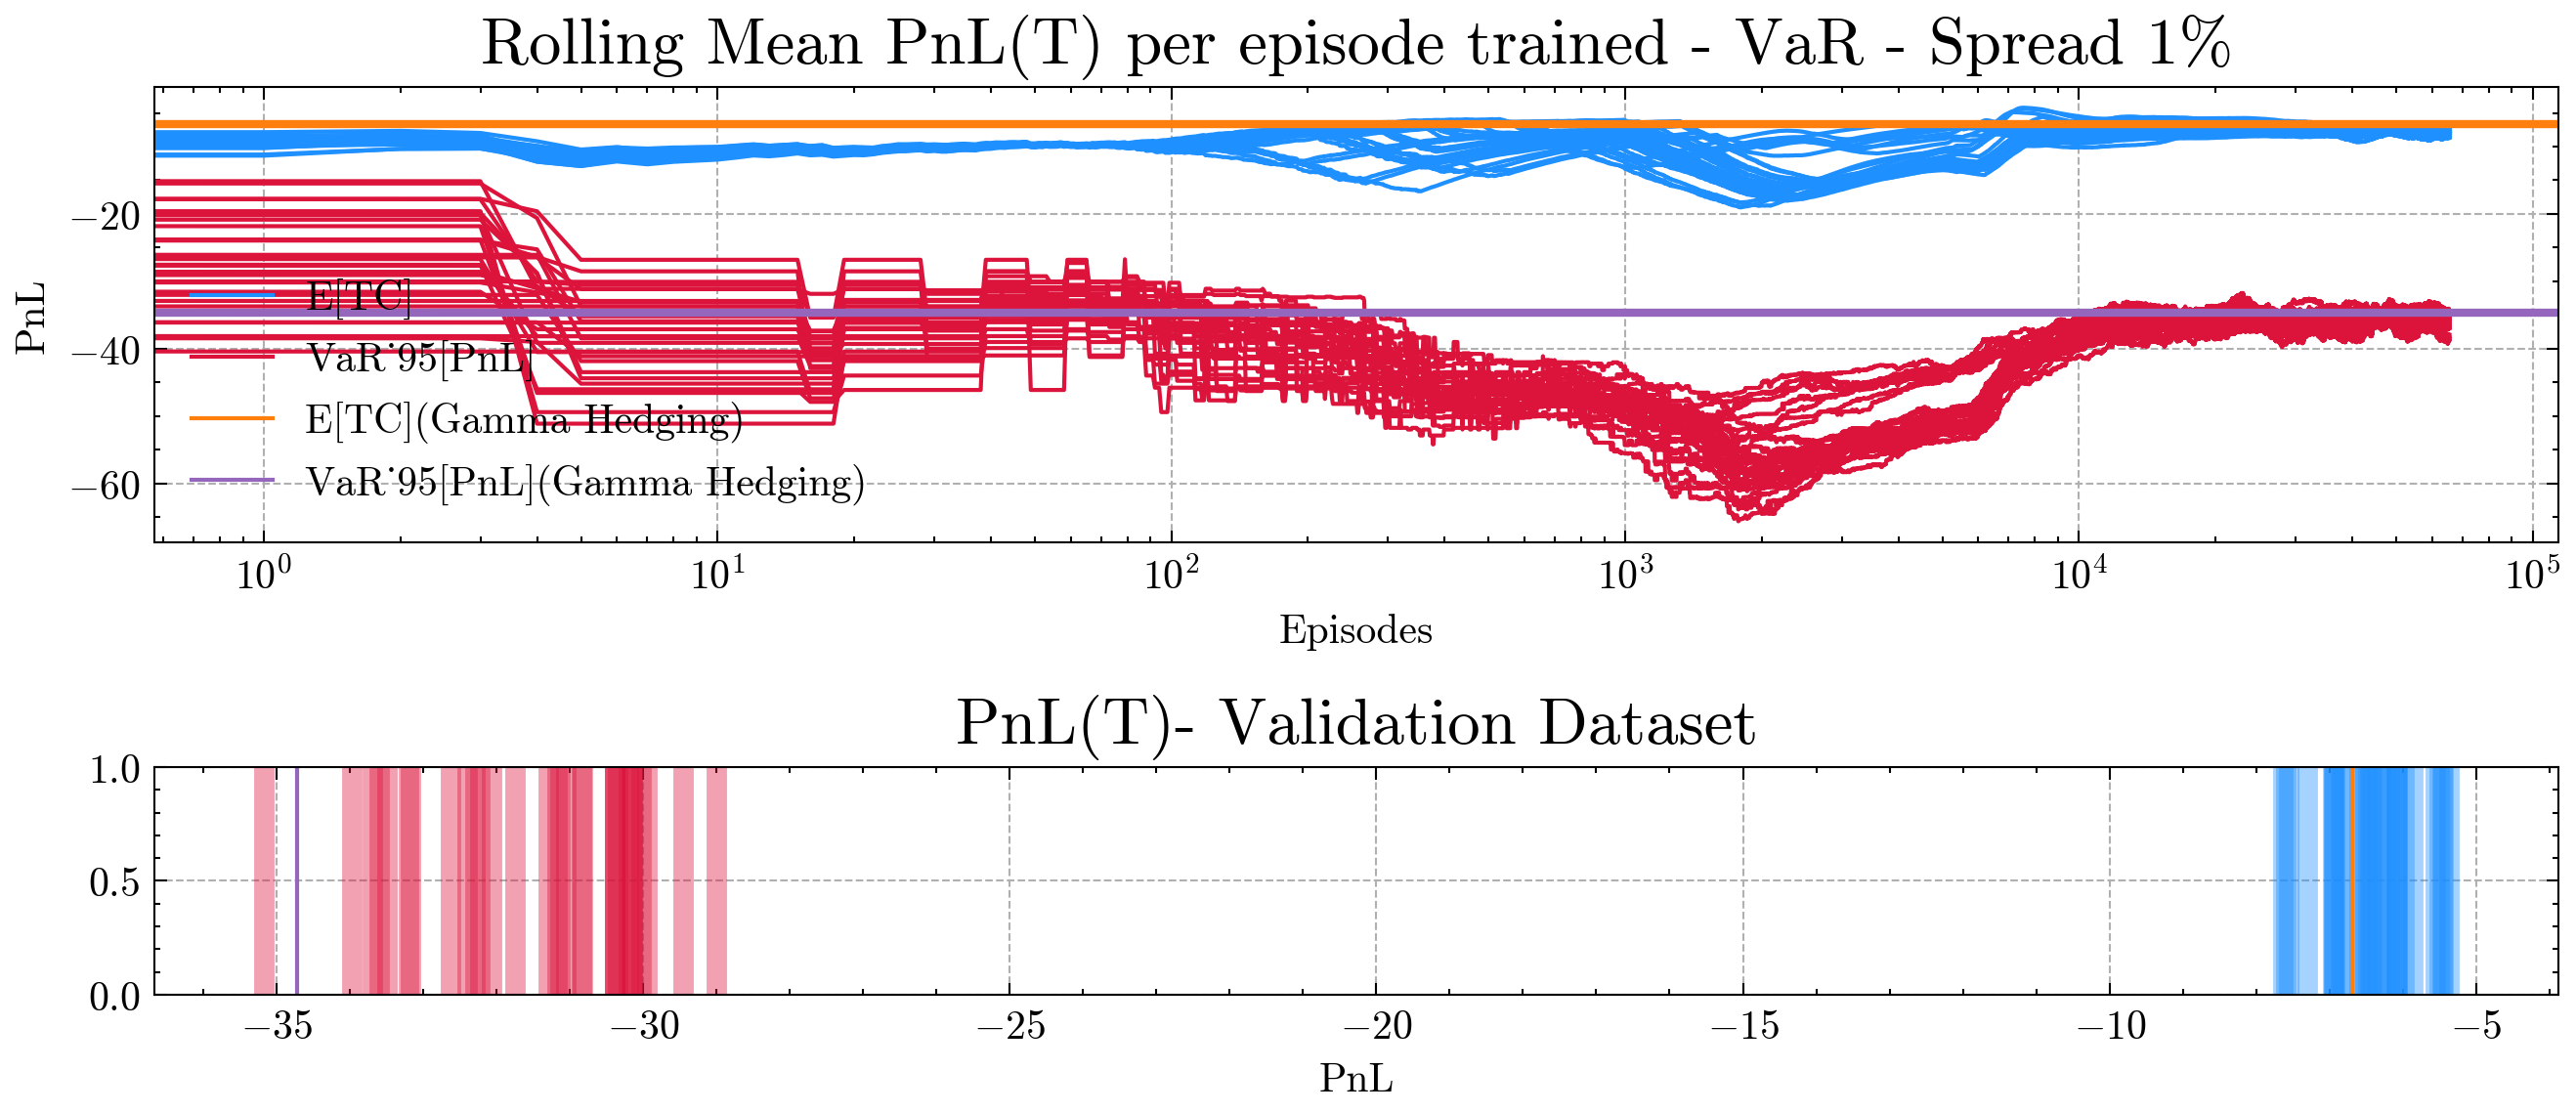

In [29]:
base_path = 'logs/(EXP 4) Heston Experiments/spread_1/Heston_VaR_Batch/'
N_E = 31
batch_template_train = (
    "Heston_VaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_VaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_VaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

# plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(9, 4), dpi=300, gridspec_kw={'height_ratios': [2, 1]})

for i in [8, 7, 13, 0, 9, 11, 18, 21, 23, 15, 27, 5, 28, 25, 10, 17, 29, 2, 6, 14, 19, 24, 12, 3, 26, 30, 20, 16, 4, 22, 1]:
    df = (
        pl_read_csv(batch_folders_train[i], n_threads=16)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_samples=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_samples=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    df = (
        pl_read_csv(batch_folders_eval[i], n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston VaR 1%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - VaR - Spread 1%", fontsize=16)
ax1.set_xlabel("Episodes", )
ax1.set_ylabel("PnL", )
ax1.set_xscale('log')
ax1.grid(True, linestyle='--')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", fontsize=16)
ax2.set_xlabel("PnL", )
ax2.grid(True, linestyle='--')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 4) Heston Experiments/spread_1/Heston_Gamma_1/greekhedge_stochastic_process=Heston_spread=0.01_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 4) Heston Experiments/spread_1/Heston_Delta_1/greekhedge_stochastic_process=Heston_spread=0.01_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Delta 1%:{i}')
generate_stat('logs/(EXP 4) Heston Experiments/spread_1/Heston_Gamma_1/greekhedge_stochastic_process=Heston_spread=0.01_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 1%:{i}')
generate_stat('logs/(EXP 4) Heston Experiments/spread_1/Heston_Vega_1/greekhedge_stochastic_process=Heston_spread=0.01_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Vega 1%:{i}')

plt.tight_layout()
plt.show()

---
# CVaR 1%

Heston CVaR 1%:4     pnl mean: -6.18 (±0.31) | std: 14.52204   | Mean-SD: -30.07 | gamma-ratio:  0.36 ( 0.07/ 0.59) | vega-ratio:  0.20 ( 0.09/ 0.33)| var95:   -29.74 | cvar95:   -39.24 | E[TC]: -6.16 (±0.04)
Heston CVaR 1%:0     pnl mean: -6.09 (±0.32) | std: 14.87214   | Mean-SD: -30.56 | gamma-ratio:  0.29 ( 0.00/ 0.53) | vega-ratio:  0.24 ( 0.11/ 0.36)| var95:   -29.98 | cvar95:   -40.66 | E[TC]: -6.35 (±0.04)
Heston CVaR 1%:19    pnl mean: -7.31 (±0.32) | std: 14.45933   | Mean-SD: -31.09 | gamma-ratio:  0.32 ( 0.03/ 0.58) | vega-ratio:  0.26 ( 0.10/ 0.42)| var95:   -30.31 | cvar95:   -40.93 | E[TC]: -7.43 (±0.05)
Heston CVaR 1%:5     pnl mean: -5.95 (±0.33) | std: 15.34399   | Mean-SD: -31.19 | gamma-ratio:  0.42 ( 0.17/ 0.62) | vega-ratio:  0.17 ( 0.07/ 0.28)| var95:   -30.55 | cvar95:   -41.78 | E[TC]: -5.94 (±0.04)
Heston CVaR 1%:16    pnl mean: -6.00 (±0.32) | std: 14.93420   | Mean-SD: -30.57 | gamma-ratio:  0.38 ( 0.10/ 0.59) | vega-ratio:  0.17 ( 0.08/ 0.27)| var95:   -30.

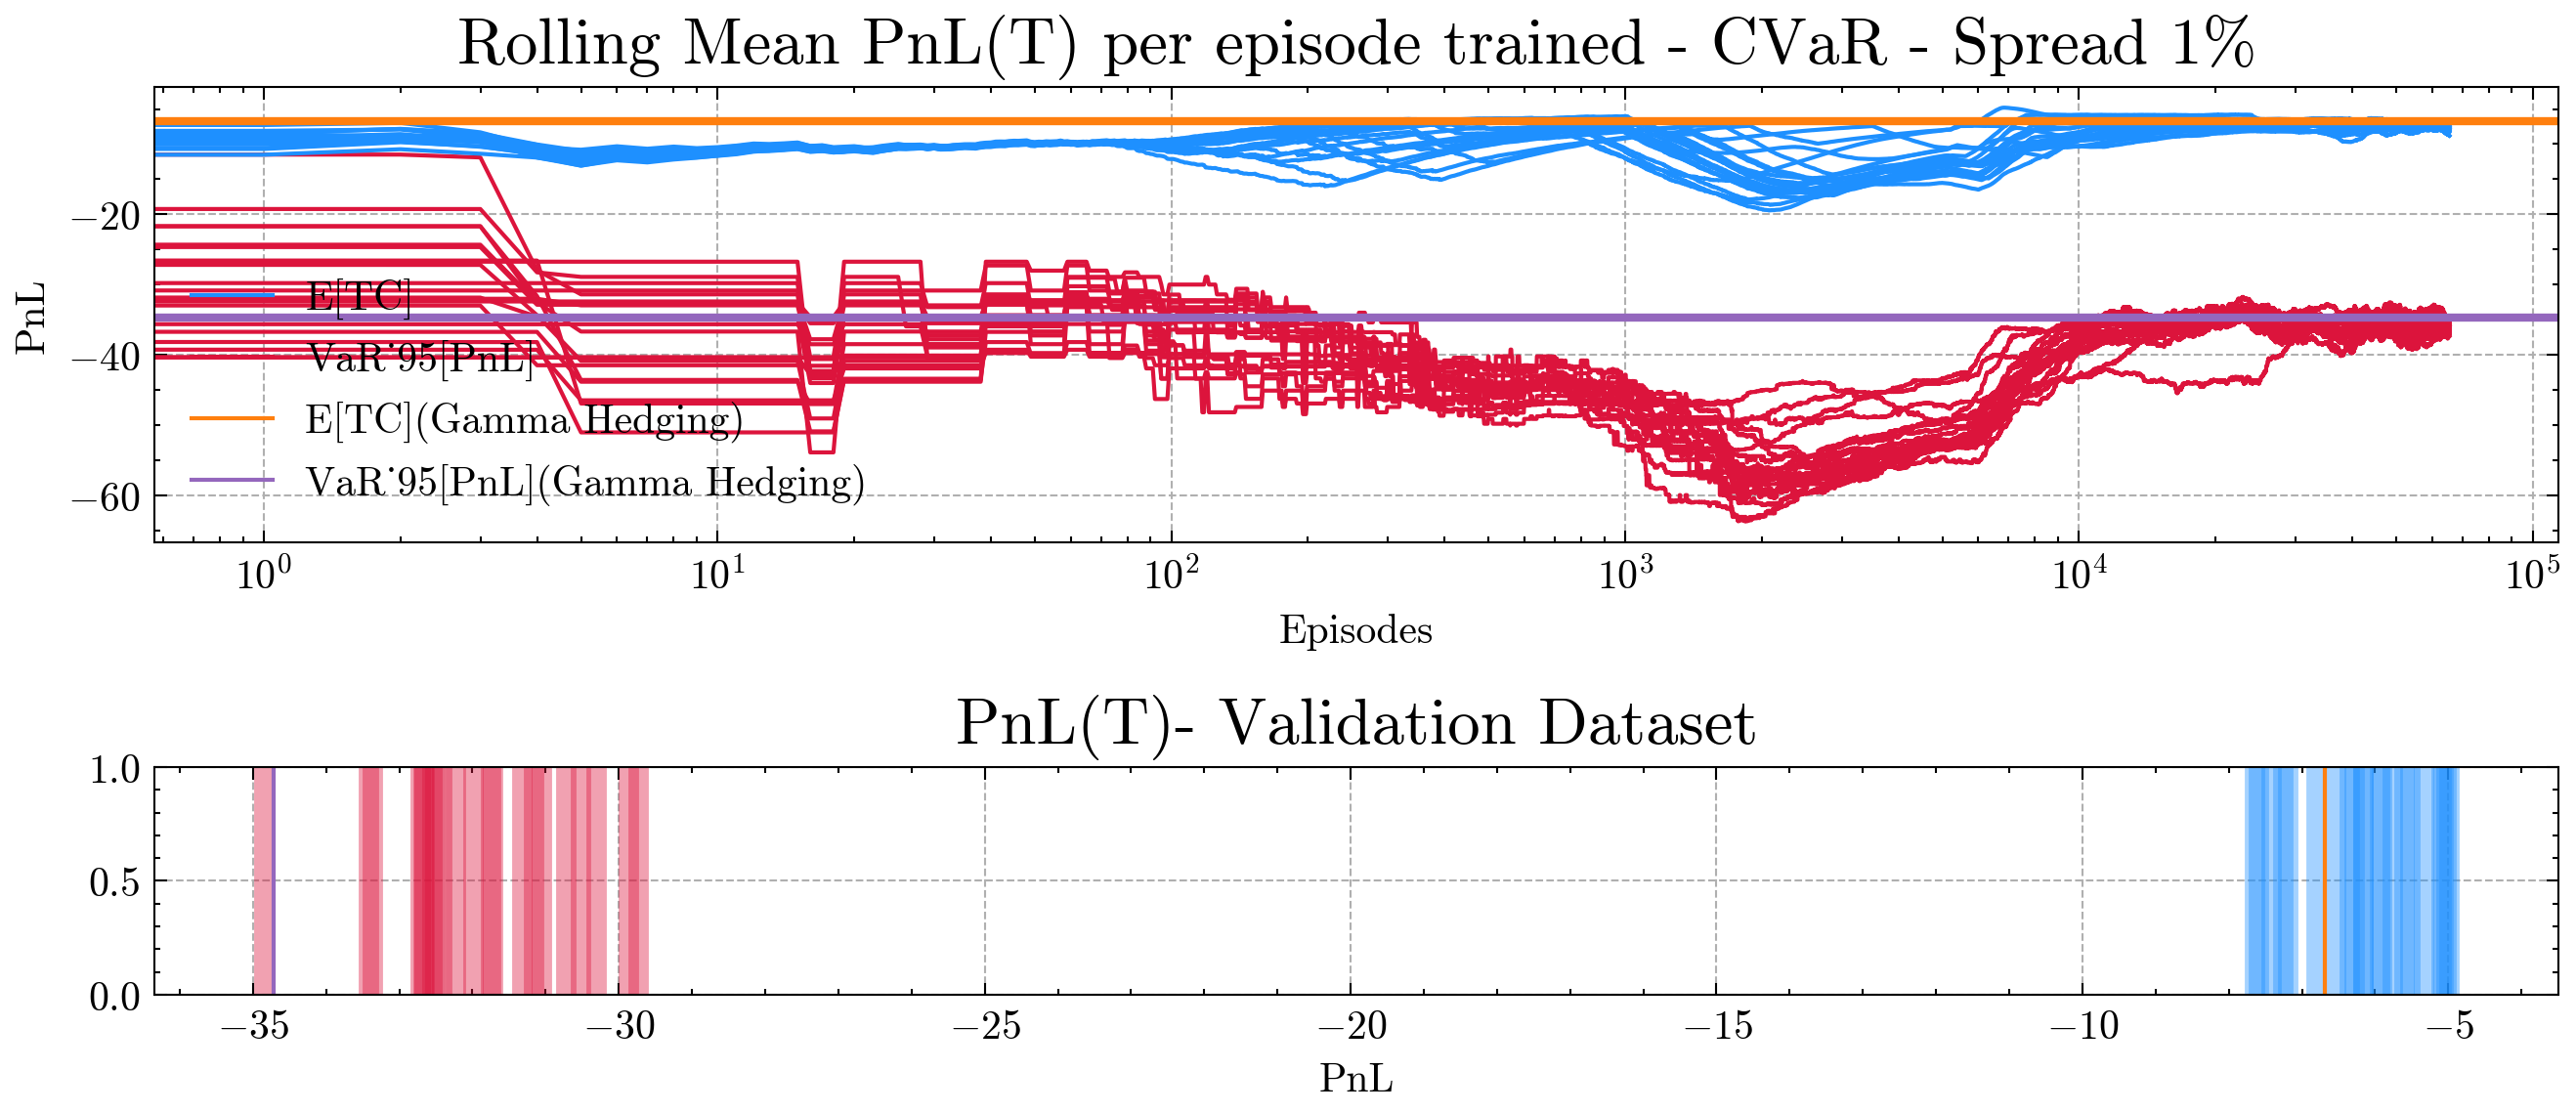

In [30]:
base_path = 'logs/(EXP 4) Heston Experiments/spread_1/Heston_CVaR_Batch/'
N_E = 21
batch_template_train = (
    "Heston_CVaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_CVaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_CVaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

# plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(9, 4), dpi=300, gridspec_kw={'height_ratios': [2, 1]})

for i in [4, 0, 19, 5, 16, 3, 6, 8, 14, 10, 11, 18, 15, 17, 20, 7, 13, 12, 2, 1, 9]:
    df = (
        pl_read_csv(batch_folders_train[i], n_threads=16)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_samples=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_samples=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    df = (
        pl_read_csv(batch_folders_eval[i], n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston CVaR 1%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - CVaR - Spread 1%", fontsize=16)
ax1.set_xlabel("Episodes", )
ax1.set_ylabel("PnL", )
ax1.set_xscale('log')
ax1.grid(True, linestyle='--')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", fontsize=16)
ax2.set_xlabel("PnL", )
ax2.grid(True, linestyle='--')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 4) Heston Experiments/spread_1/Heston_Gamma_1/greekhedge_stochastic_process=Heston_spread=0.01_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 4) Heston Experiments/spread_1/Heston_Delta_1/greekhedge_stochastic_process=Heston_spread=0.01_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Delta 1%:{i}')
generate_stat('logs/(EXP 4) Heston Experiments/spread_1/Heston_Gamma_1/greekhedge_stochastic_process=Heston_spread=0.01_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 1%:{i}')
generate_stat('logs/(EXP 4) Heston Experiments/spread_1/Heston_Vega_1/greekhedge_stochastic_process=Heston_spread=0.01_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Vega 1%:{i}')

plt.tight_layout()
plt.show()

---
# VaR 2%

Heston VaR 2%:4      pnl mean: -8.58 (±0.35) | std: 16.09227   | Mean-SD: -35.05 | gamma-ratio:  0.23 ( 0.06/ 0.38) | vega-ratio:  0.16 ( 0.07/ 0.24)| var95:   -34.84 | cvar95:   -45.43 | E[TC]: -8.78 (±0.06)
Heston VaR 2%:0      pnl mean: -9.82 (±0.34) | std: 15.48953   | Mean-SD: -35.30 | gamma-ratio:  0.31 ( 0.08/ 0.48) | vega-ratio:  0.16 ( 0.08/ 0.24)| var95:   -34.98 | cvar95:   -45.87 | E[TC]: -9.81 (±0.07)
Heston VaR 2%:10     pnl mean: -9.74 (±0.34) | std: 15.58749   | Mean-SD: -35.38 | gamma-ratio:  0.33 ( 0.12/ 0.49) | vega-ratio:  0.16 ( 0.07/ 0.26)| var95:   -35.56 | cvar95:   -46.07 | E[TC]: -9.81 (±0.06)
Heston VaR 2%:20     pnl mean: -10.18(±0.33) | std: 15.27882   | Mean-SD: -35.31 | gamma-ratio:  0.26 ( 0.03/ 0.45) | vega-ratio:  0.18 ( 0.10/ 0.26)| var95:   -35.69 | cvar95:   -46.20 | E[TC]: -10.18(±0.07)
Heston VaR 2%:8      pnl mean: -8.14 (±0.37) | std: 16.65840   | Mean-SD: -35.54 | gamma-ratio:  0.27 ( 0.11/ 0.43) | vega-ratio:  0.09 ( 0.04/ 0.15)| var95:   -36.

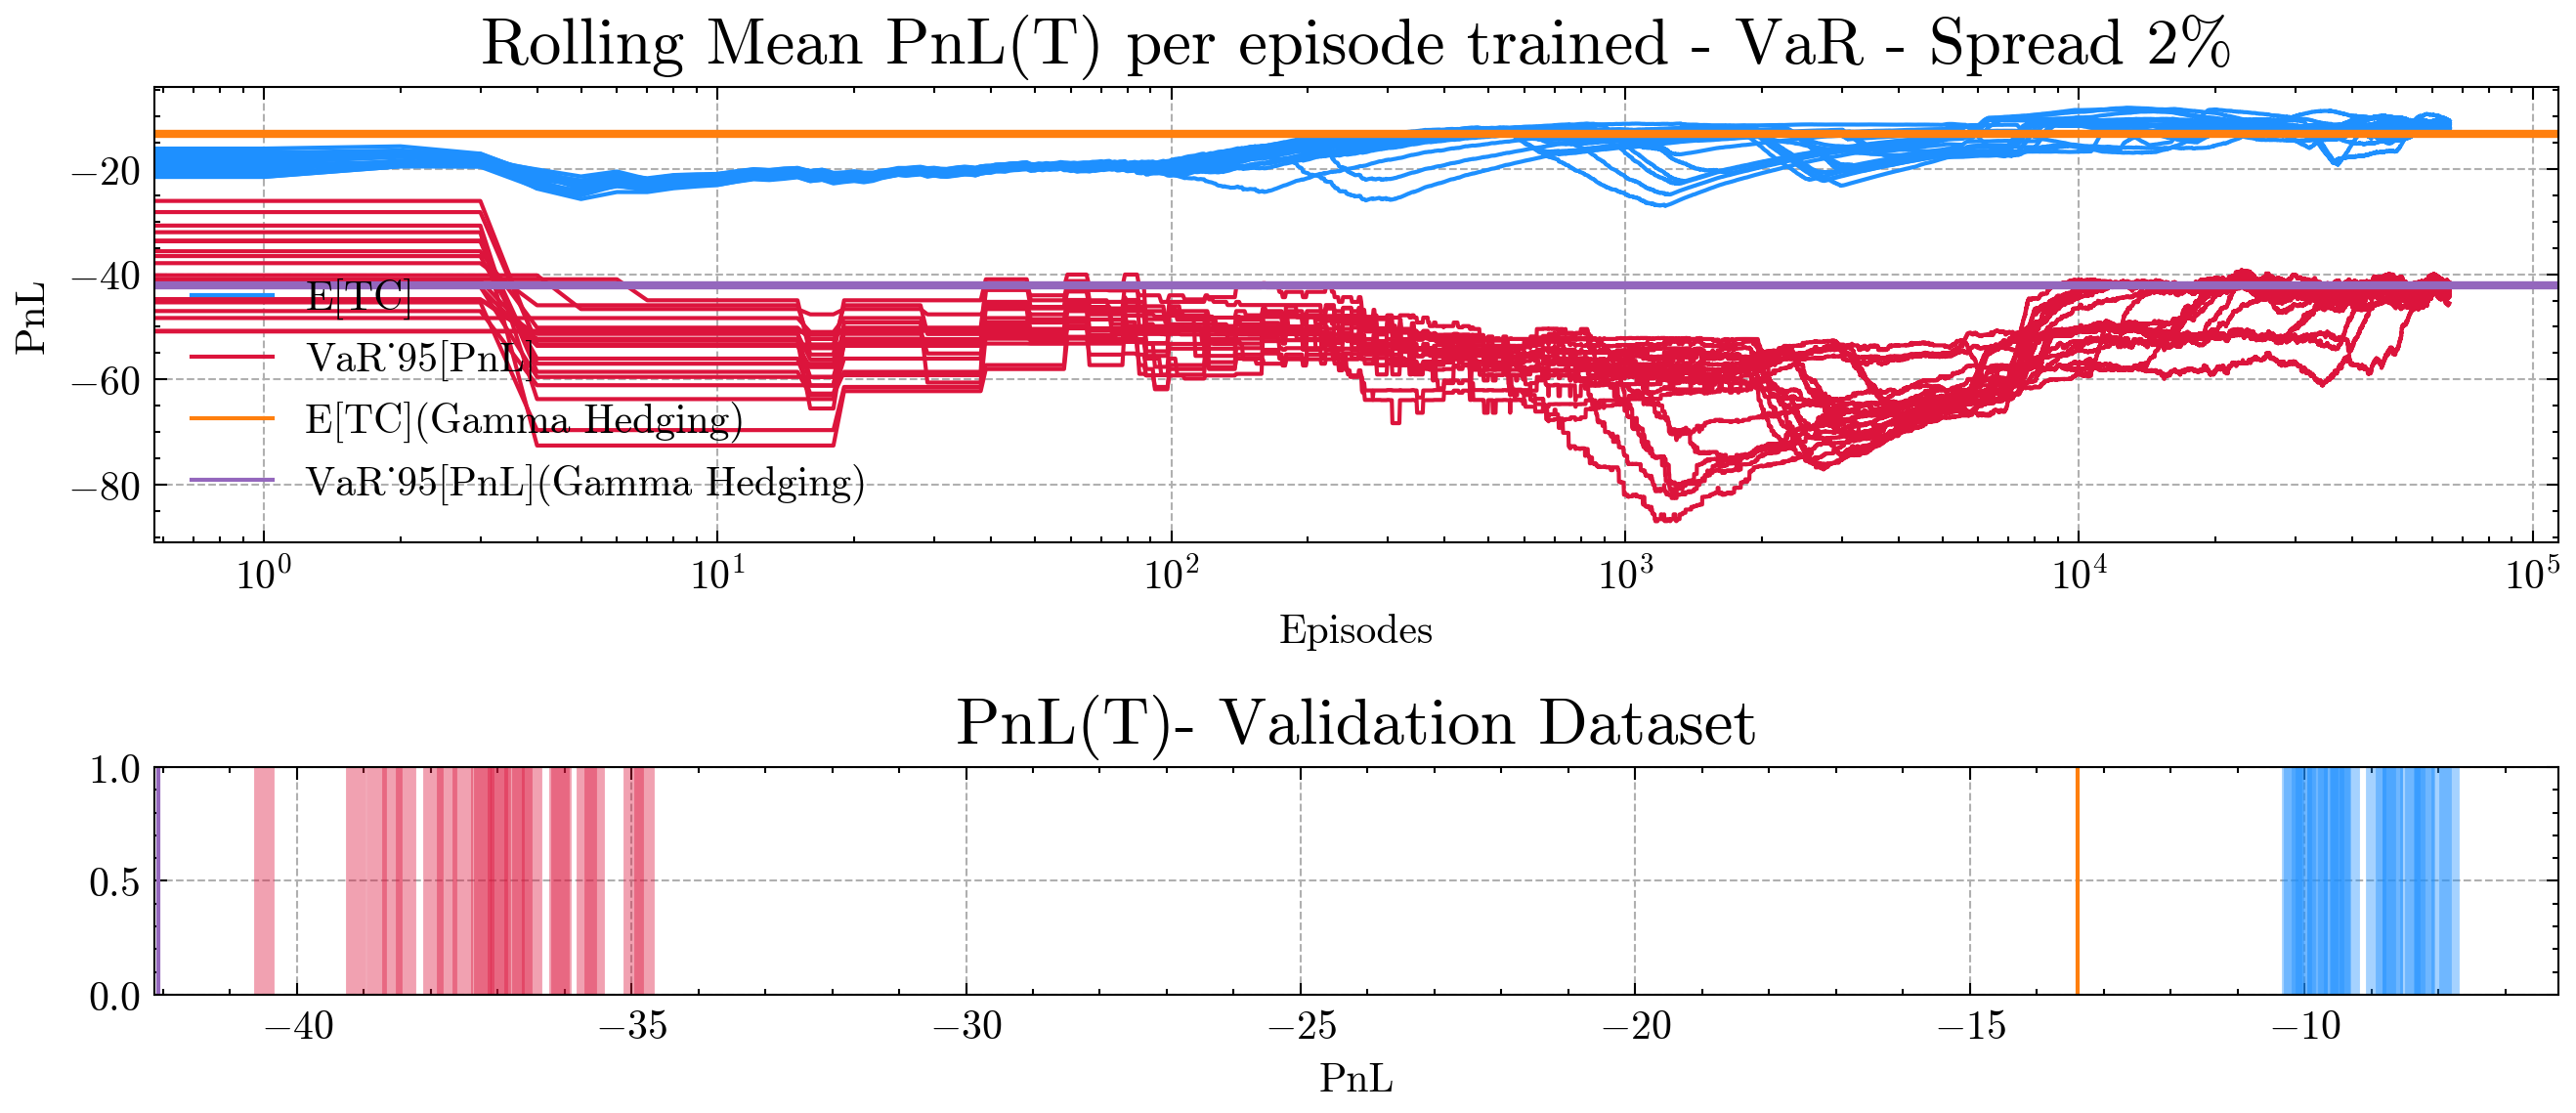

In [31]:
base_path = 'logs/(EXP 4) Heston Experiments/spread_2/Heston_VaR_Batch/'
N_E = 21
batch_template_train = (
    "Heston_VaR_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_VaR_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_VaR_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

# plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(9, 4), dpi=300, gridspec_kw={'height_ratios': [2, 1]})

for i in [4, 0, 10, 20, 8, 5, 9, 11, 19, 13, 2, 18, 16, 7, 17, 1, 6, 14, 3, 15, 12]:
    df = (
        pl_read_csv(batch_folders_train[i], n_threads=16)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_samples=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_samples=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    df = (
        pl_read_csv(batch_folders_eval[i], n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston VaR 2%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - VaR - Spread 2%", fontsize=16)
ax1.set_xlabel("Episodes", )
ax1.set_ylabel("PnL", )
ax1.set_xscale('log')
ax1.grid(True, linestyle='--')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", fontsize=16)
ax2.set_xlabel("PnL", )
ax2.grid(True, linestyle='--')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 4) Heston Experiments/spread_2/Heston_Gamma_2/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 4) Heston Experiments/spread_2/Heston_Delta_2/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Delta 2%')
generate_stat('logs/(EXP 4) Heston Experiments/spread_2/Heston_Gamma_2/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 2%')
generate_stat('logs/(EXP 4) Heston Experiments/spread_2/Heston_Vega_2/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Vega 2%')

plt.tight_layout()
plt.show()

---
# Mean-Std 2%

Heston Mean Std 2%:6 pnl mean: -9.96 (±0.33) | std: 15.07959   | Mean-SD: -34.77 | gamma-ratio:  0.29 ( 0.06/ 0.47) | vega-ratio:  0.18 ( 0.10/ 0.28)| var95:   -34.99 | cvar95:   -46.59 | E[TC]: -9.88 (±0.06)
Heston Mean Std 2%:18 pnl mean: -10.19(±0.32) | std: 14.97308   | Mean-SD: -34.82 | gamma-ratio:  0.23 ( 0.01/ 0.42) | vega-ratio:  0.18 ( 0.11/ 0.26)| var95:   -35.05 | cvar95:   -45.20 | E[TC]: -10.21(±0.06)
Heston Mean Std 2%:16 pnl mean: -11.02(±0.32) | std: 14.46784   | Mean-SD: -34.82 | gamma-ratio:  0.29 ( 0.05/ 0.52) | vega-ratio:  0.21 ( 0.11/ 0.32)| var95:   -35.22 | cvar95:   -45.44 | E[TC]: -10.99(±0.07)
Heston Mean Std 2%:14 pnl mean: -8.87 (±0.35) | std: 16.28113   | Mean-SD: -35.65 | gamma-ratio:  0.28 ( 0.10/ 0.42) | vega-ratio:  0.14 ( 0.06/ 0.23)| var95:   -35.26 | cvar95:   -47.07 | E[TC]: -8.80 (±0.06)
Heston Mean Std 2%:7 pnl mean: -10.27(±0.33) | std: 15.18857   | Mean-SD: -35.26 | gamma-ratio:  0.30 ( 0.05/ 0.47) | vega-ratio:  0.17 ( 0.09/ 0.25)| var95:   -

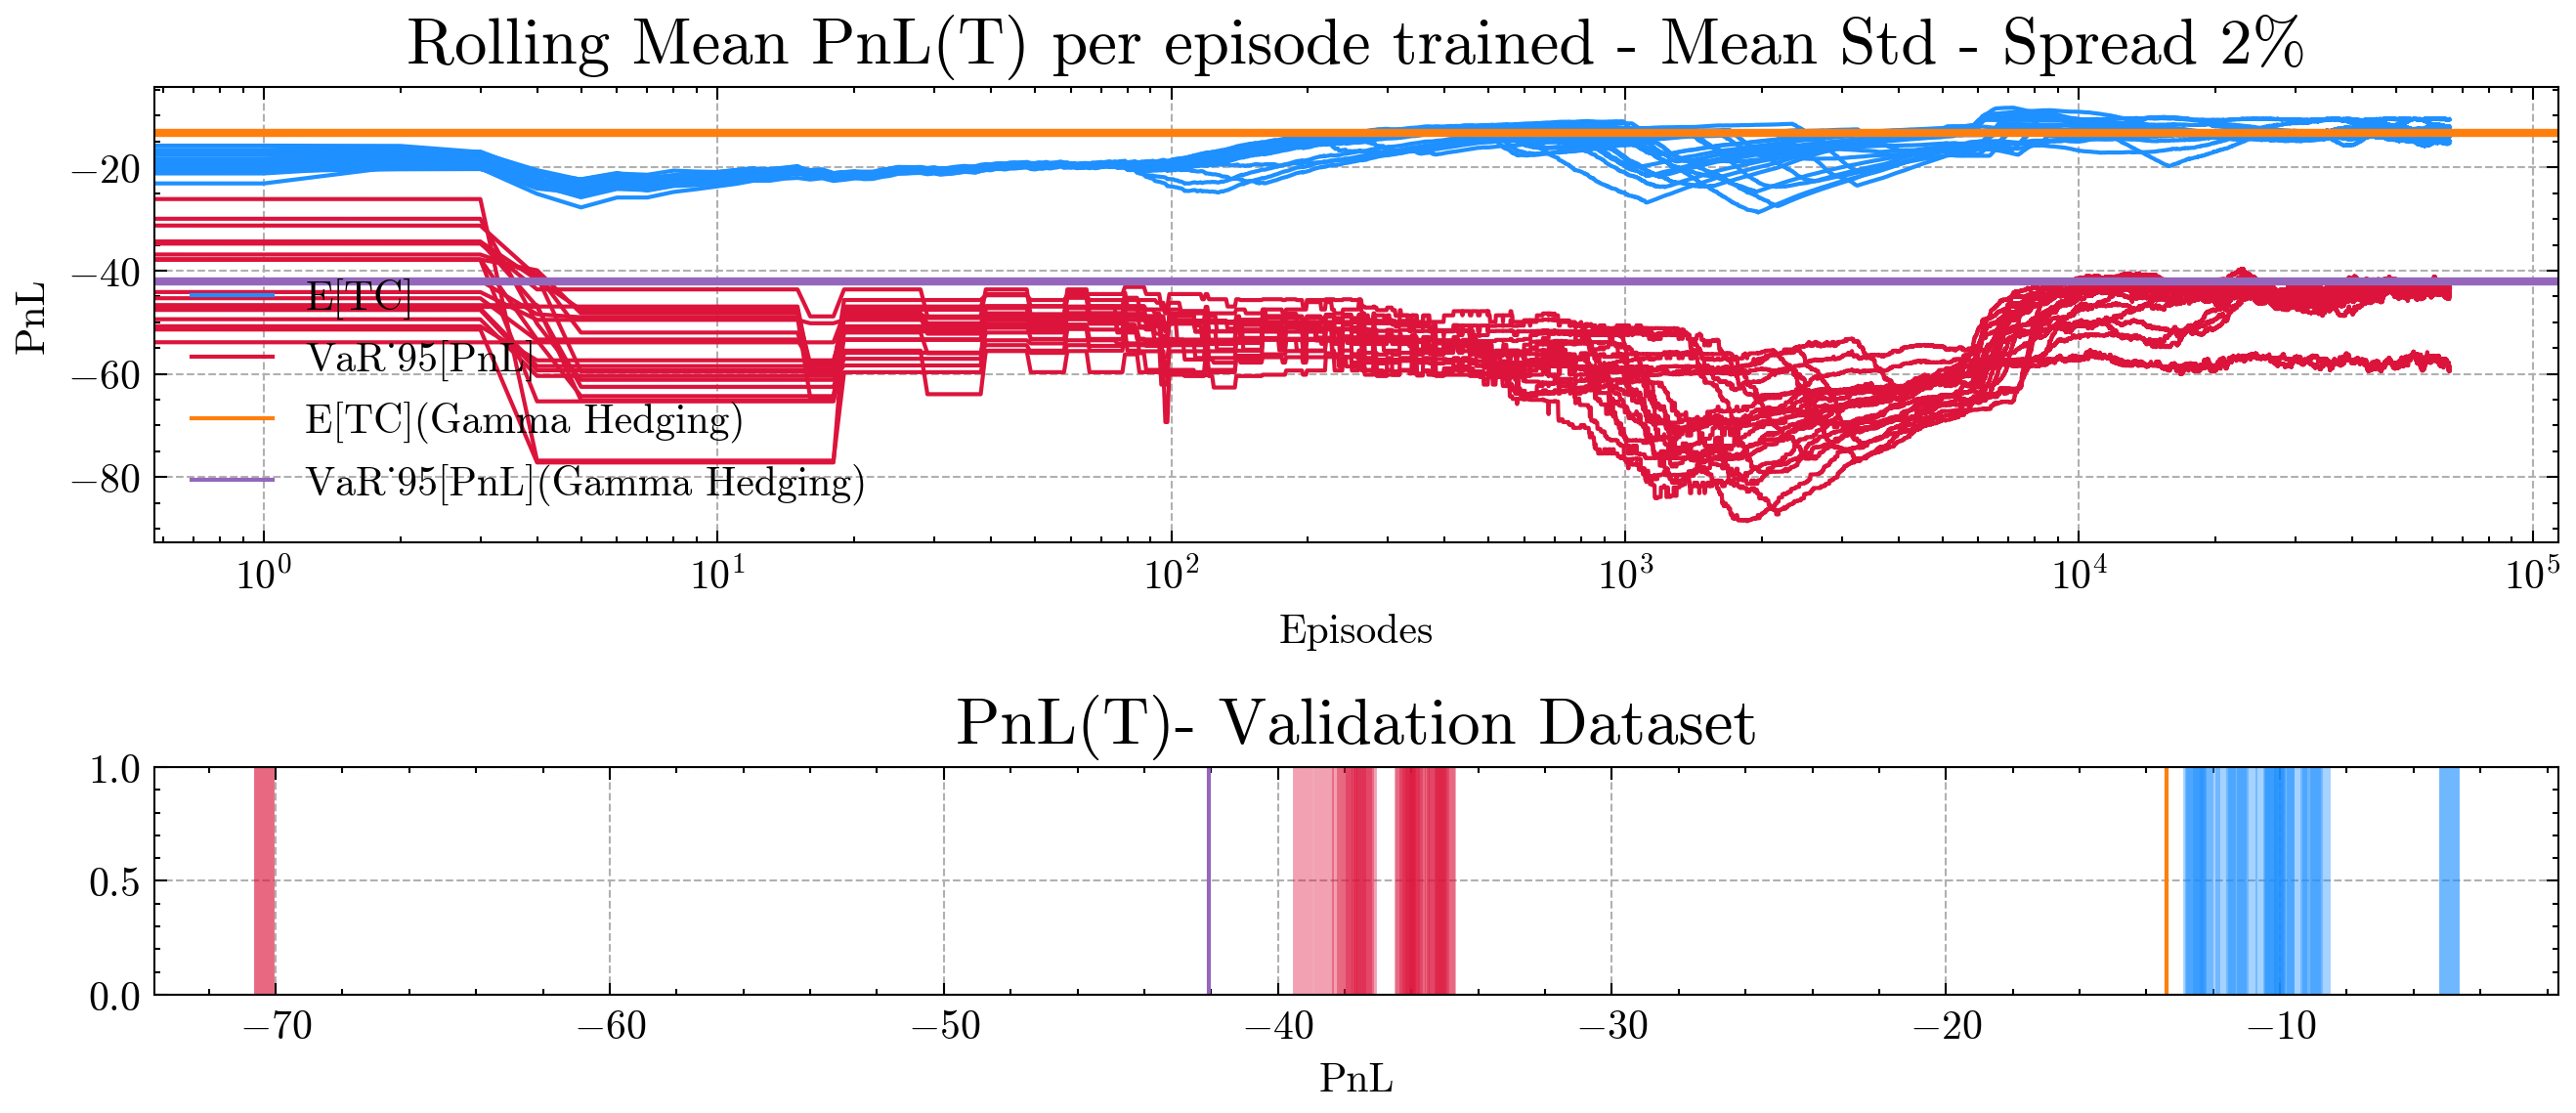

In [32]:
base_path = 'logs/(EXP 4) Heston Experiments/spread_2/Heston_Mean_Std_Batch/'
N_E = 21
batch_template_train = (
    "Heston_Mean_Std_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_Mean_Std_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_Mean_Std_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

# plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(9, 4), dpi=300, gridspec_kw={'height_ratios': [2, 1]})

for i in [6, 18, 16, 14, 7, 9, 10, 8, 4, 3, 11, 5, 13, 12, 1, 17, 19, 2, 0, 15, 20]:
    df = (
        pl_read_csv(batch_folders_train[i])#, n_threads=1)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_samples=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_samples=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    df = (
        pl_read_csv(batch_folders_eval[i])#, n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Mean Std 2%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - Mean Std - Spread 2%", fontsize=16)
ax1.set_xlabel("Episodes", )
ax1.set_ylabel("PnL", )
ax1.set_xscale('log')
ax1.grid(True, linestyle='--')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", fontsize=16)
ax2.set_xlabel("PnL", )
ax2.grid(True, linestyle='--')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 4) Heston Experiments/spread_2/Heston_Gamma_2/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 4) Heston Experiments/spread_2/Heston_Delta_2/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Delta 2%')
generate_stat('logs/(EXP 4) Heston Experiments/spread_2/Heston_Gamma_2/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 2%')
generate_stat('logs/(EXP 4) Heston Experiments/spread_2/Heston_Vega_2/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Vega 2%')

plt.tight_layout()
plt.show()


---
---
---
# VaR 0.5% P Measure

Heston VaR 0.5%:6    pnl mean: -3.30 (±0.30) | std: 13.75259   | Mean-SD: -25.93 | gamma-ratio:  0.40 ( 0.04/ 0.72) | vega-ratio:  0.30 ( 0.13/ 0.47)| var95:   -25.12 | cvar95:   -35.61 | E[TC]: -3.44 (±0.02)
Heston VaR 0.5%:9    pnl mean: -3.05 (±0.31) | std: 14.27514   | Mean-SD: -26.53 | gamma-ratio:  0.38 ( 0.04/ 0.66) | vega-ratio:  0.25 ( 0.12/ 0.37)| var95:   -25.41 | cvar95:   -36.57 | E[TC]: -3.21 (±0.02)
Heston VaR 0.5%:3    pnl mean: -3.20 (±0.30) | std: 14.07255   | Mean-SD: -26.35 | gamma-ratio:  0.33 ( 0.01/ 0.61) | vega-ratio:  0.27 ( 0.13/ 0.42)| var95:   -25.68 | cvar95:   -36.40 | E[TC]: -3.31 (±0.02)
Heston VaR 0.5%:10   pnl mean: -3.76 (±0.30) | std: 13.74431   | Mean-SD: -26.37 | gamma-ratio:  0.33 ( 0.00/ 0.65) | vega-ratio:  0.33 ( 0.15/ 0.51)| var95:   -25.80 | cvar95:   -35.97 | E[TC]: -3.83 (±0.02)
Heston VaR 0.5%:19   pnl mean: -3.27 (±0.31) | std: 13.98450   | Mean-SD: -26.28 | gamma-ratio:  0.38 ( 0.04/ 0.67) | vega-ratio:  0.25 ( 0.12/ 0.39)| var95:   -25.

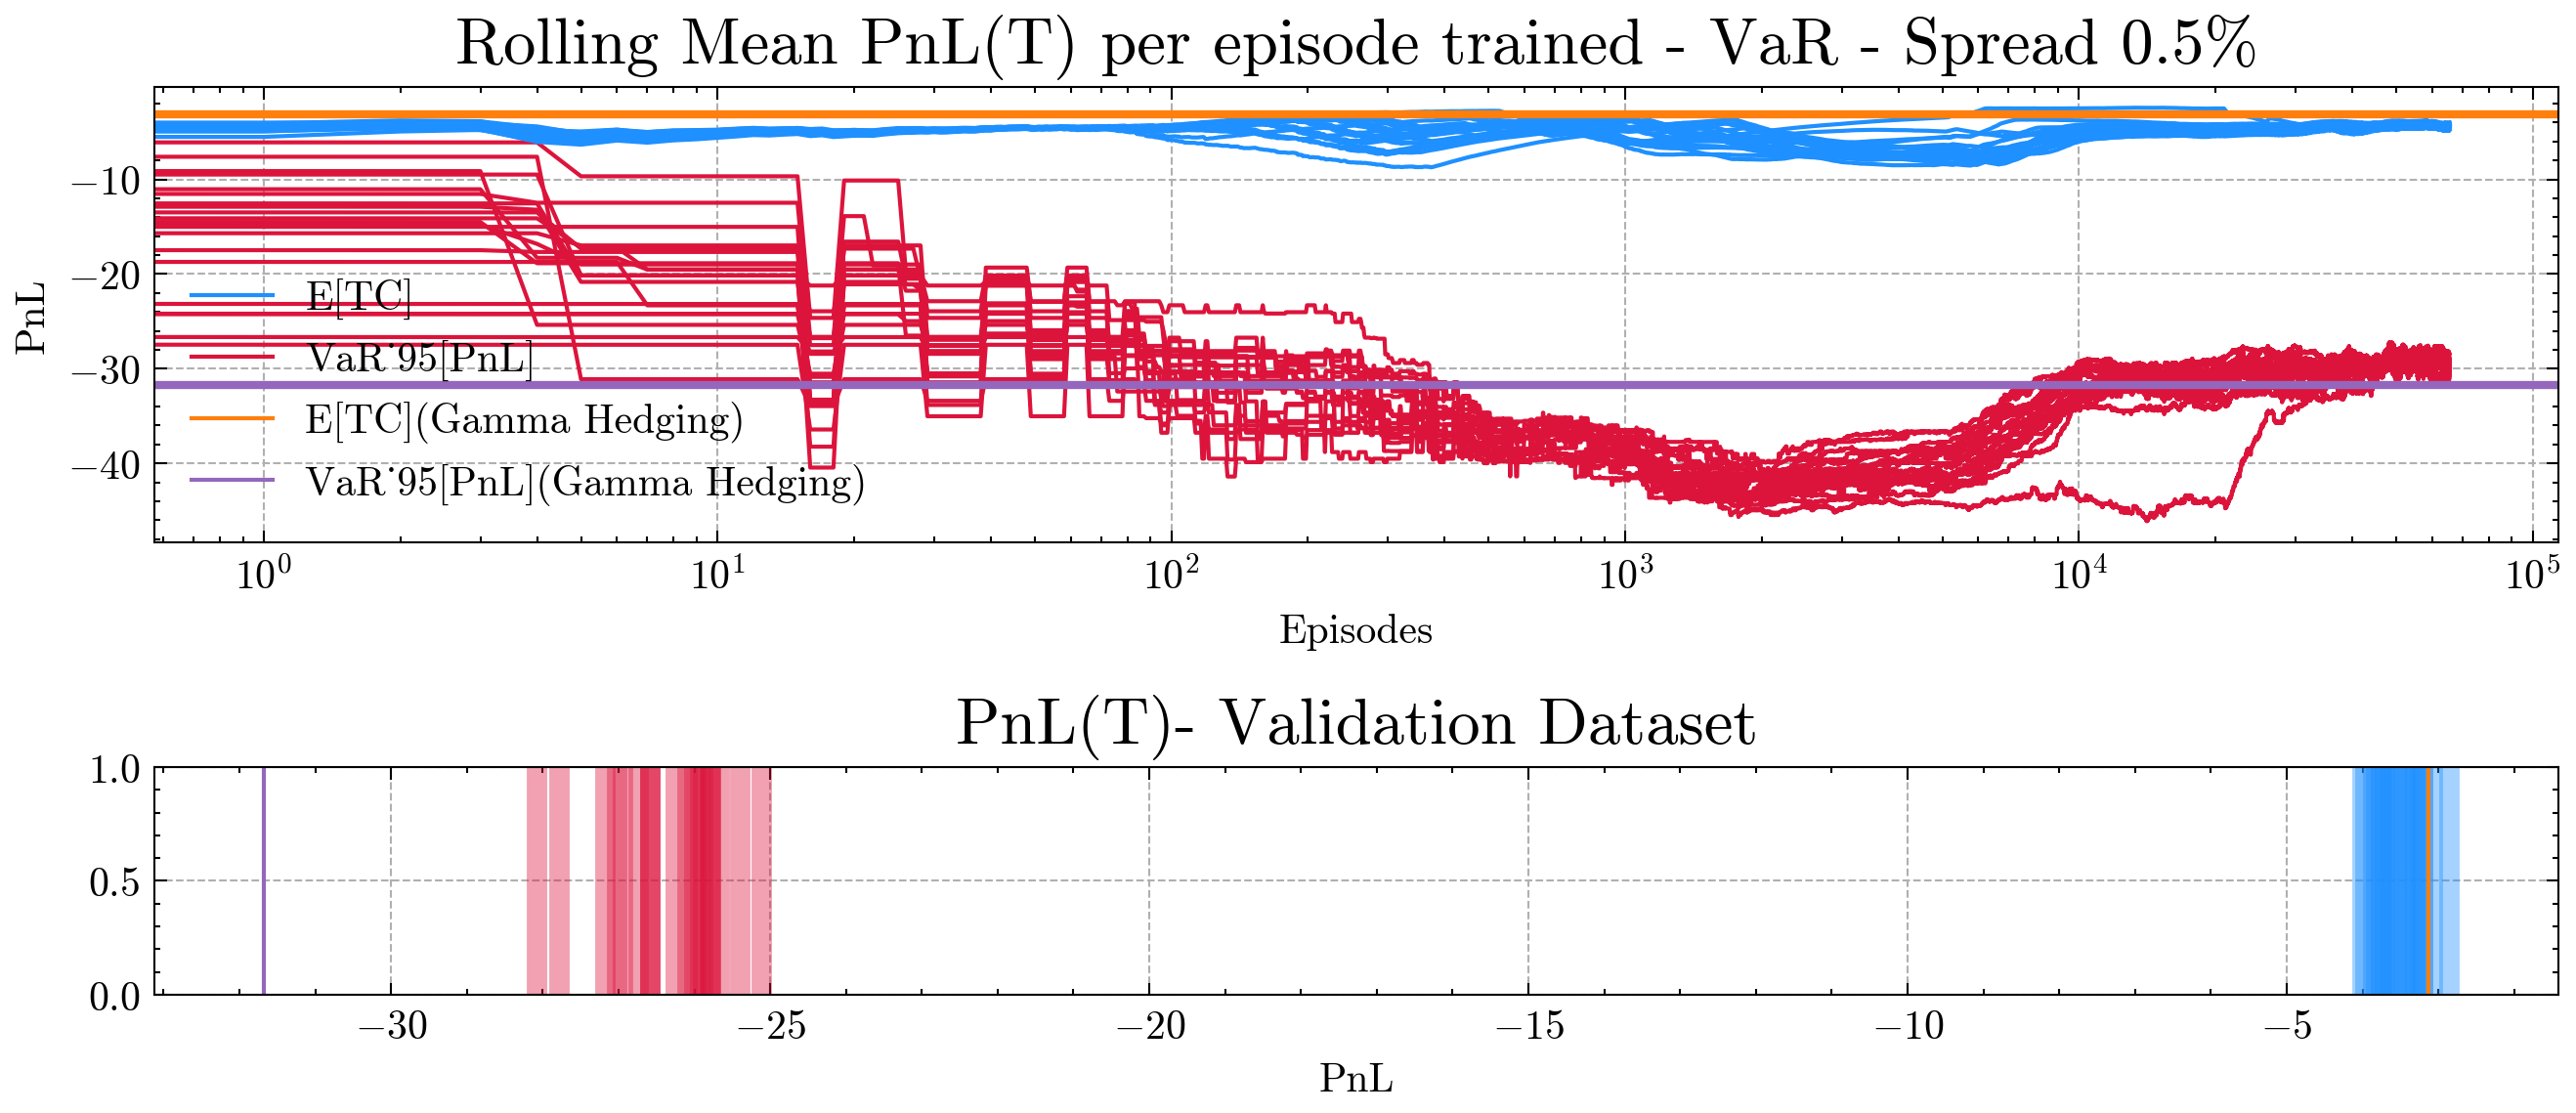

In [23]:
base_path = 'logs/(EXP 5) Heston P-Measure/spread_05/'
N_E = 21
batch_template_train = (
    "Heston_VaR_P_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_VaR_P_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_VaR_P_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

# plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(9, 4), dpi=300, gridspec_kw={'height_ratios': [2, 1]})

ids = [6, 9, 3, 10, 19, 2, 4, 13, 7, 20, 12, 11, 15, 0, 16, 14, 8, 1, 5, 18, 17]
for i in ids:
    df = (
        pl_read_csv(batch_folders_train[i])
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_samples=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_samples=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    df = (
        pl_read_csv(batch_folders_eval[i])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston VaR 0.5%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - VaR - Spread 0.5%", fontsize=16)
ax1.set_xlabel("Episodes", )
ax1.set_ylabel("PnL", )
ax1.set_xscale('log')
ax1.grid(True, linestyle='--')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", fontsize=16)
ax2.set_xlabel("PnL", )
ax2.grid(True, linestyle='--')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 5) Heston P-Measure/spread_05/Heston_Gamma_P/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 5) Heston P-Measure/spread_05/Heston_Delta_P/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Delta 0.5%:{i}')
generate_stat('logs/(EXP 5) Heston P-Measure/spread_05/Heston_Gamma_P/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 0.5%:{i}')
generate_stat('logs/(EXP 5) Heston P-Measure/spread_05/Heston_Vega_P/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Vega 0.5%:{i}')

plt.tight_layout()
plt.show()

---
# VaR 1% P Measure

Heston VaR 1%:19     pnl mean: -5.50 (±0.31) | std: 14.55127   | Mean-SD: -29.43 | gamma-ratio:  0.26 (-0.00/ 0.51) | vega-ratio:  0.24 ( 0.13/ 0.35)| var95:   -28.55 | cvar95:   -38.68 | E[TC]: -5.61 (±0.03)
Heston VaR 1%:16     pnl mean: -5.51 (±0.32) | std: 14.60167   | Mean-SD: -29.53 | gamma-ratio:  0.32 ( 0.05/ 0.55) | vega-ratio:  0.21 ( 0.10/ 0.31)| var95:   -28.73 | cvar95:   -39.76 | E[TC]: -5.61 (±0.04)
Heston VaR 1%:6      pnl mean: -5.56 (±0.31) | std: 14.17150   | Mean-SD: -28.87 | gamma-ratio:  0.37 ( 0.08/ 0.60) | vega-ratio:  0.20 ( 0.10/ 0.31)| var95:   -28.95 | cvar95:   -39.19 | E[TC]: -5.64 (±0.04)
Heston VaR 1%:18     pnl mean: -5.56 (±0.32) | std: 14.46632   | Mean-SD: -29.36 | gamma-ratio:  0.30 ( 0.04/ 0.53) | vega-ratio:  0.22 ( 0.11/ 0.32)| var95:   -29.12 | cvar95:   -39.56 | E[TC]: -5.69 (±0.03)
Heston VaR 1%:20     pnl mean: -6.08 (±0.31) | std: 14.32424   | Mean-SD: -29.65 | gamma-ratio:  0.36 ( 0.03/ 0.63) | vega-ratio:  0.25 ( 0.13/ 0.38)| var95:   -29.

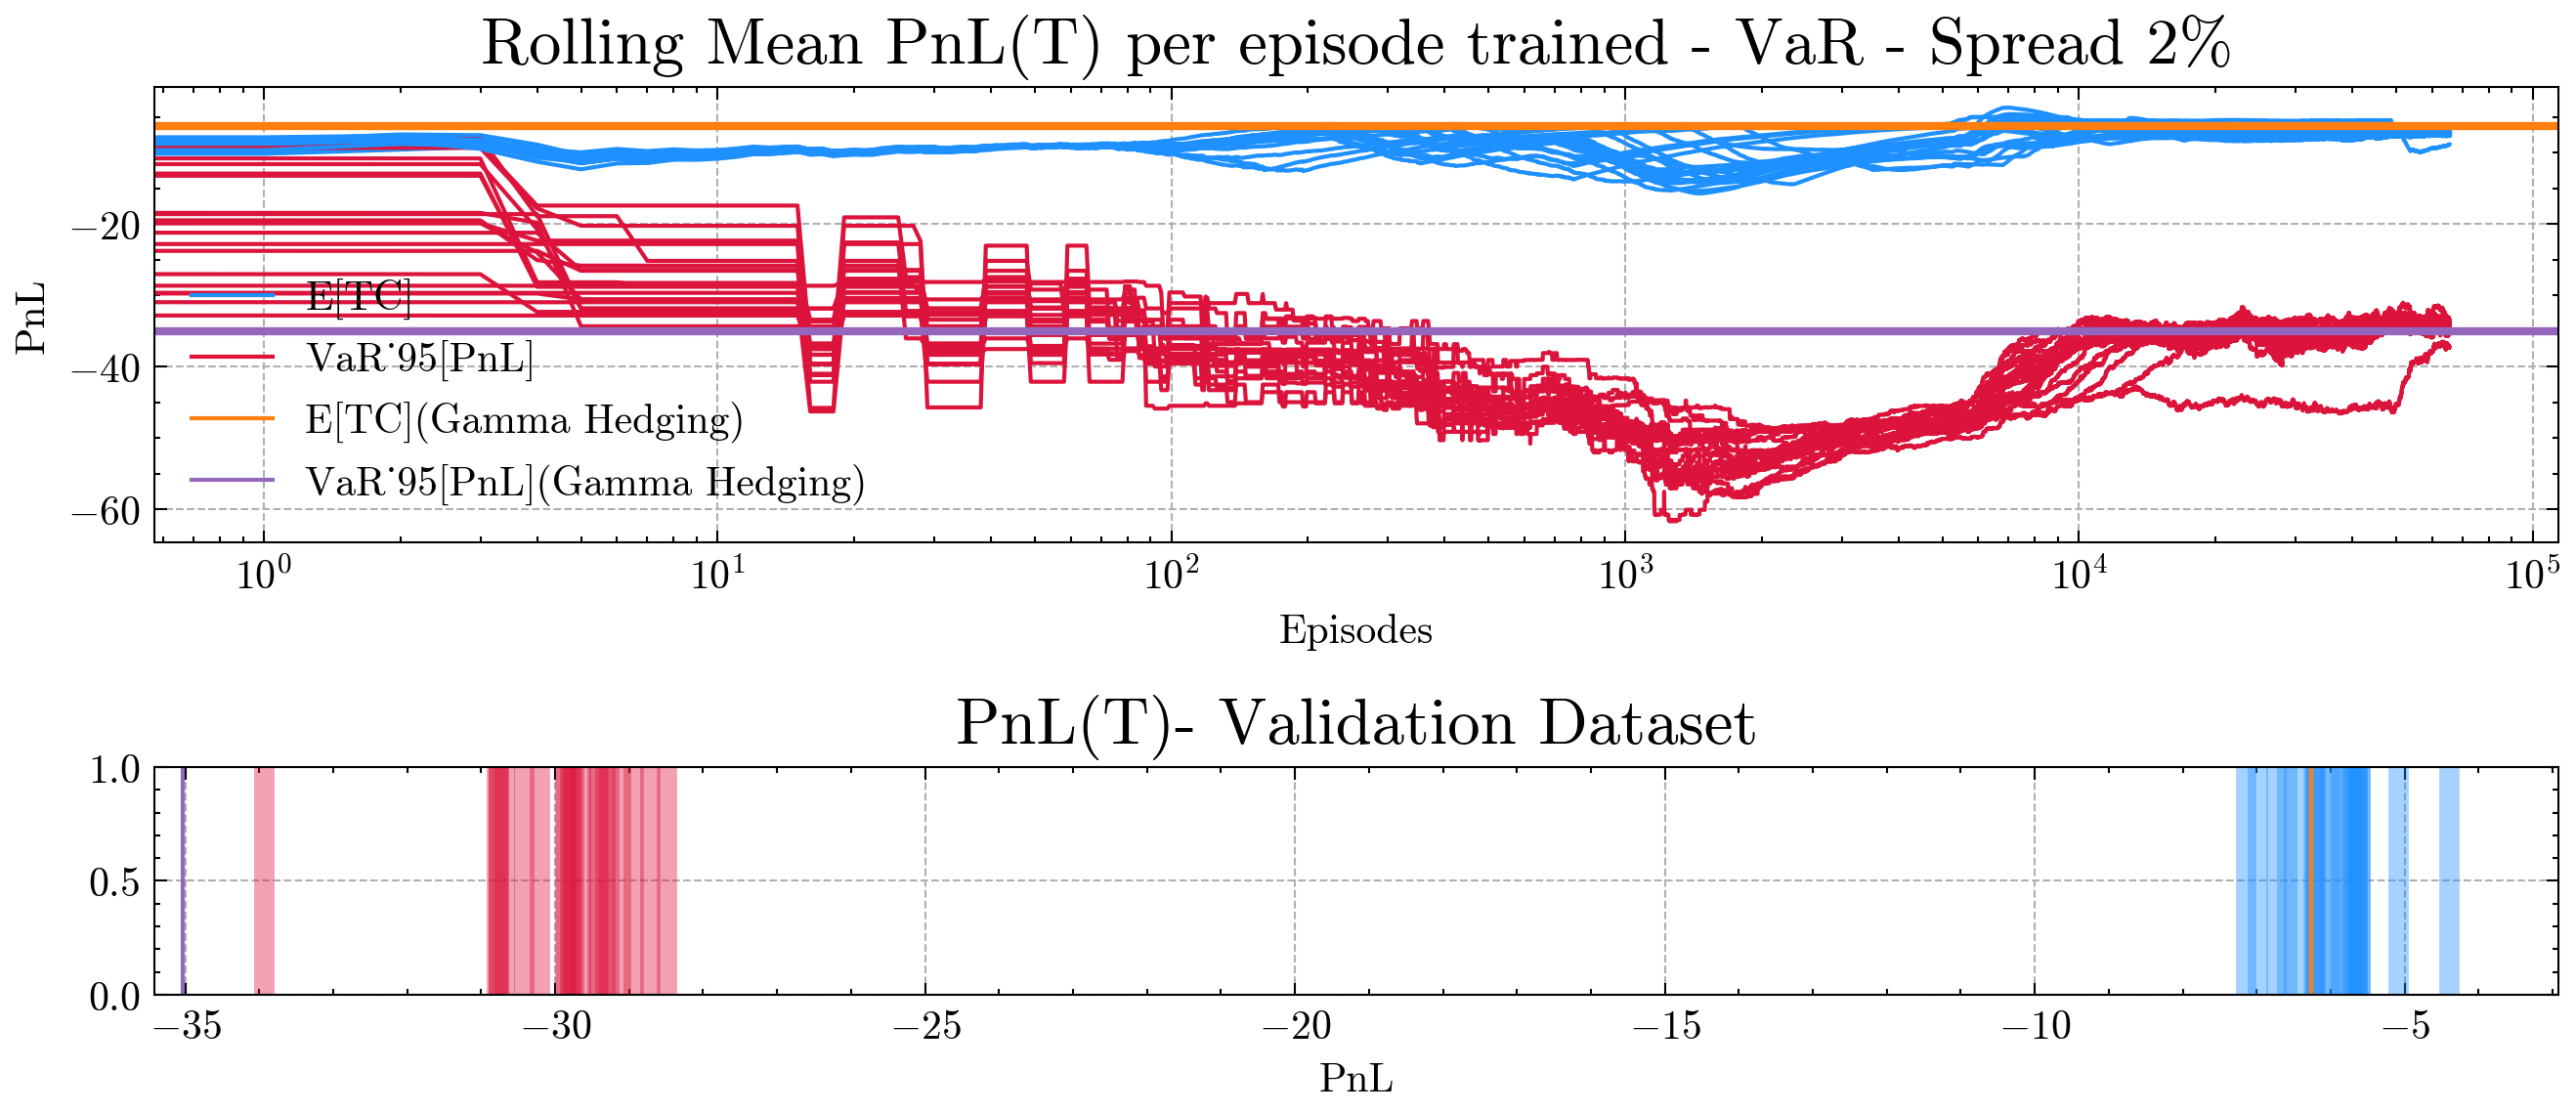

In [22]:
base_path = 'logs/(EXP 5) Heston P-Measure/spread_1/'
N_E = 21
batch_template_train = (
    "Heston_VaR_P_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_VaR_P_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_VaR_P_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

# plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(9, 4), dpi=300, gridspec_kw={'height_ratios': [2, 1]})

ids = [19, 16, 6, 18, 20, 9, 8, 17, 5, 1, 2, 7, 14, 11, 3, 4, 10, 0, 13, 15, 12]
for i in ids:
    df = (
        pl_read_csv(batch_folders_train[i], n_threads=16)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_samples=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_samples=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    df = (
        pl_read_csv(batch_folders_eval[i], n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston VaR 1%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - VaR - Spread 2%", fontsize=16)
ax1.set_xlabel("Episodes", )
ax1.set_ylabel("PnL", )
ax1.set_xscale('log')
ax1.grid(True, linestyle='--')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", fontsize=16)
ax2.set_xlabel("PnL", )
ax2.grid(True, linestyle='--')

# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 5) Heston P-Measure/spread_1/Heston_Gamma_P/greekhedge_stochastic_process=Heston_spread=0.01_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 5) Heston P-Measure/spread_1/Heston_Delta_P/greekhedge_stochastic_process=Heston_spread=0.01_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Delta 1%:{i}')
generate_stat('logs/(EXP 5) Heston P-Measure/spread_1/Heston_Gamma_P/greekhedge_stochastic_process=Heston_spread=0.01_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 1%:{i}')
generate_stat('logs/(EXP 5) Heston P-Measure/spread_1/Heston_Vega_P/greekhedge_stochastic_process=Heston_spread=0.01_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Vega 1%:{i}')

plt.tight_layout()
plt.show()

---
# VaR 2% P Measure

Heston VaR 2%:8      pnl mean: -9.38 (±0.32) | std: 15.19475   | Mean-SD: -34.37 | gamma-ratio:  0.33 ( 0.08/ 0.52) | vega-ratio:  0.18 ( 0.09/ 0.27)| var95:   -34.72 | cvar95:   -45.14 | E[TC]: -9.39 (±0.06)
Heston VaR 2%:6      pnl mean: -9.56 (±0.32) | std: 15.10491   | Mean-SD: -34.41 | gamma-ratio:  0.24 ( 0.00/ 0.45) | vega-ratio:  0.18 ( 0.10/ 0.27)| var95:   -34.78 | cvar95:   -45.64 | E[TC]: -9.59 (±0.07)
Heston VaR 2%:18     pnl mean: -9.52 (±0.34) | std: 15.43907   | Mean-SD: -34.92 | gamma-ratio:  0.20 (-0.03/ 0.43) | vega-ratio:  0.20 ( 0.13/ 0.27)| var95:   -35.00 | cvar95:   -45.82 | E[TC]: -9.72 (±0.07)
Heston VaR 2%:13     pnl mean: -8.93 (±0.35) | std: 15.75737   | Mean-SD: -34.85 | gamma-ratio:  0.31 ( 0.06/ 0.51) | vega-ratio:  0.17 ( 0.09/ 0.25)| var95:   -35.09 | cvar95:   -46.36 | E[TC]: -9.01 (±0.06)
Heston VaR 2%:10     pnl mean: -9.53 (±0.33) | std: 15.28187   | Mean-SD: -34.67 | gamma-ratio:  0.27 ( 0.05/ 0.47) | vega-ratio:  0.18 ( 0.09/ 0.27)| var95:   -35.

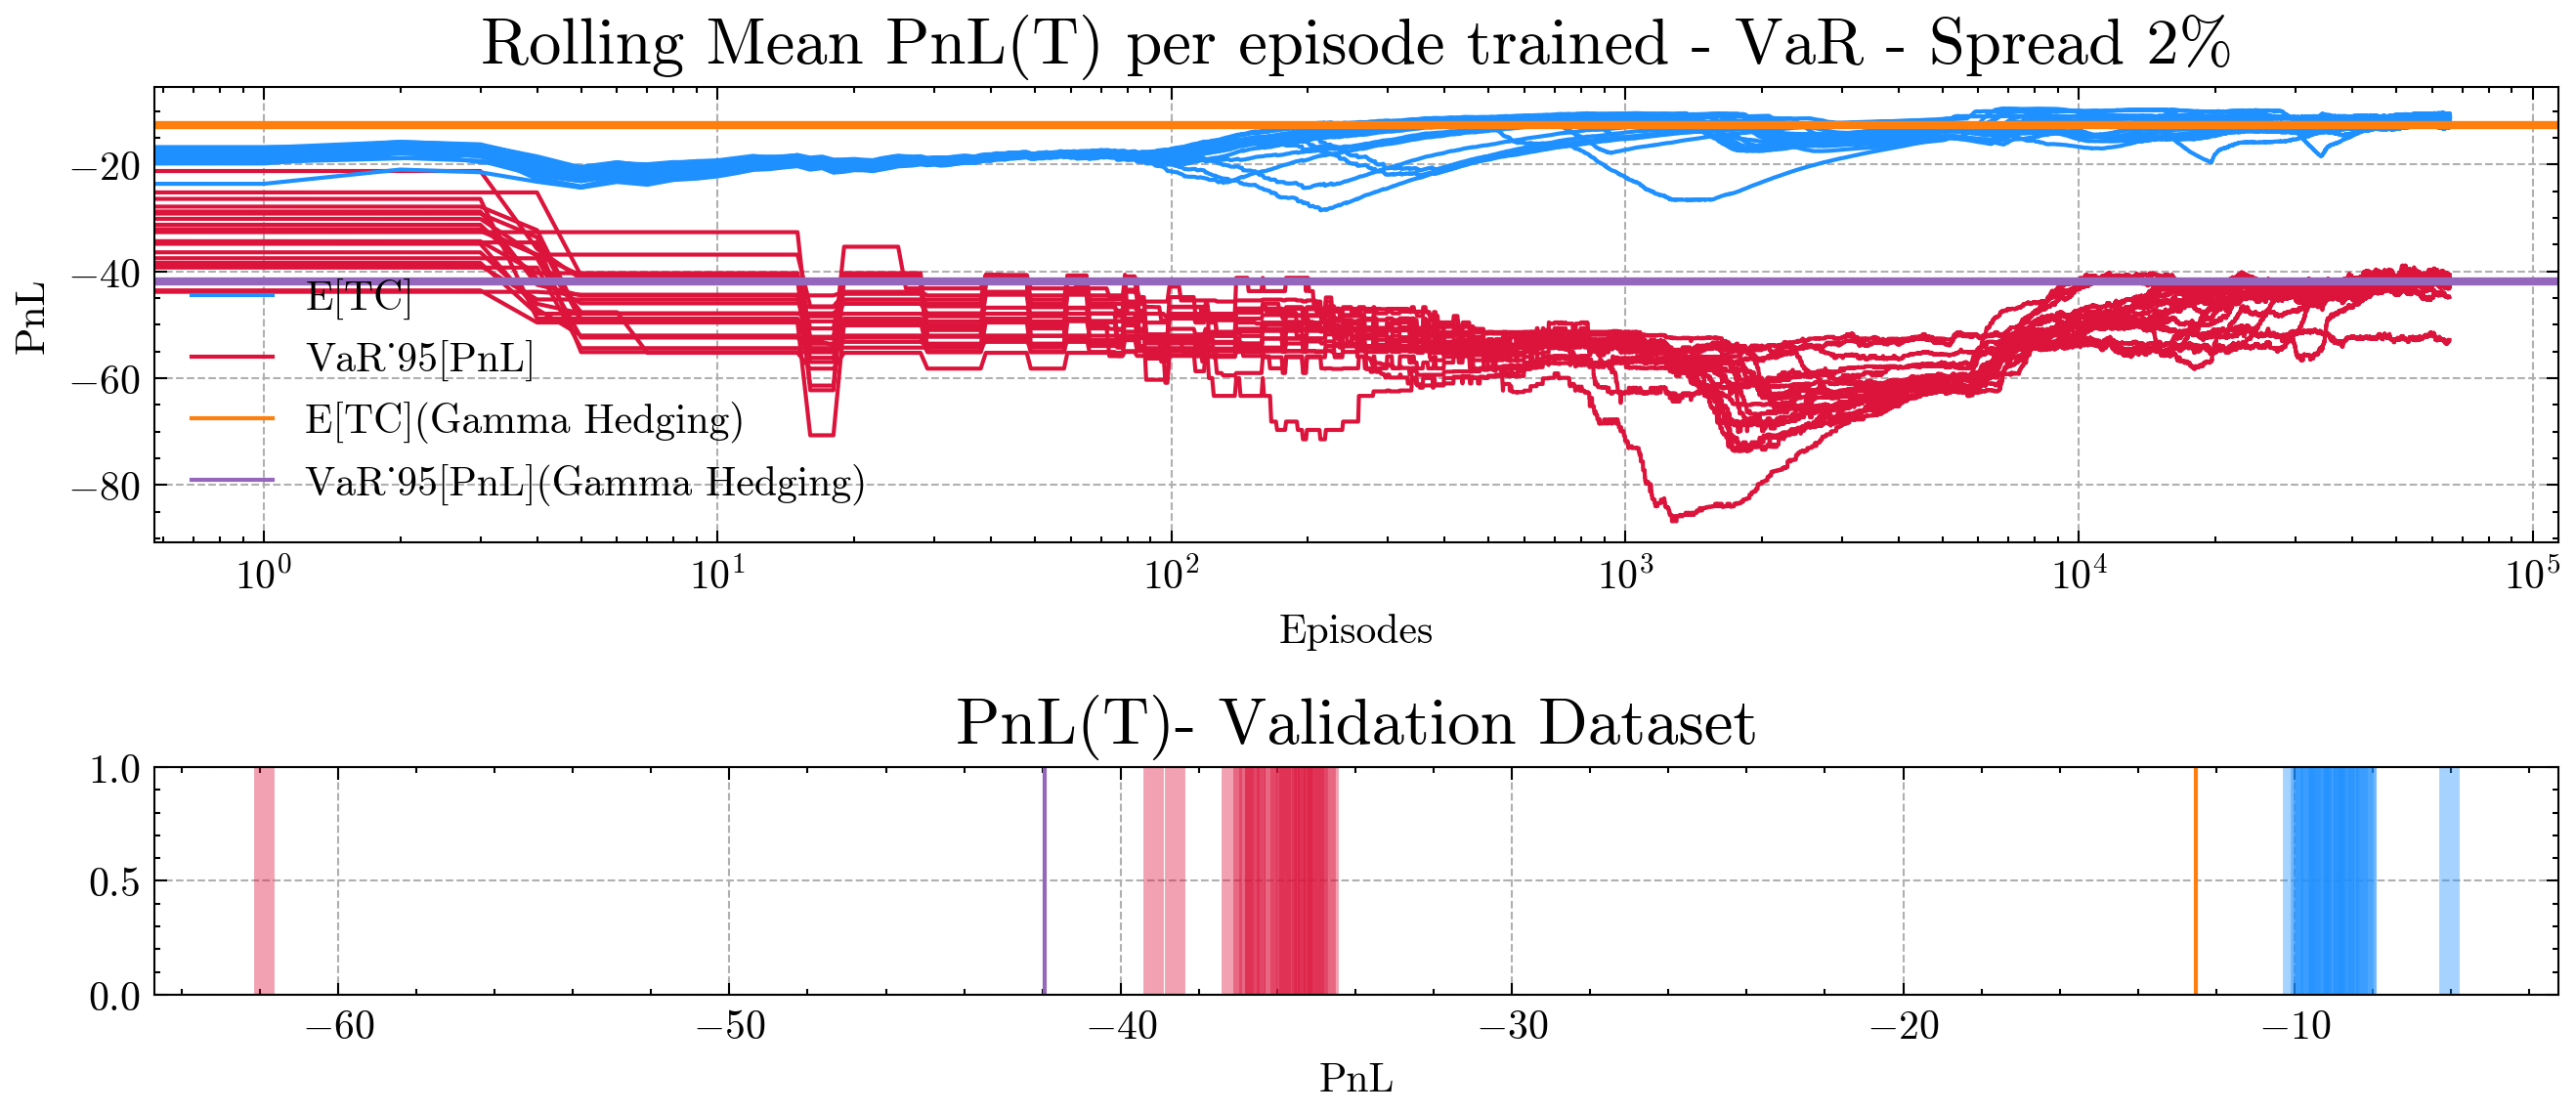

In [21]:
plt.style.use(['science', 'no-latex'])

base_path = 'logs/(EXP 5) Heston P-Measure/spread_2/'
N_E = 21
batch_template_train = (
    "Heston_VaR_P_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_VaR_P_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_VaR_P_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

# plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(9, 4), dpi=300, gridspec_kw={'height_ratios': [2, 1]})

ids = [8, 6, 18, 13, 10, 3, 20, 12, 2, 7, 17, 0, 14, 15, 16, 5, 9, 11, 1, 4, 19]
for i in ids:
    df = (
        pl_read_csv(batch_folders_train[i], n_threads=16)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_samples=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_samples=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    df = (
        pl_read_csv(batch_folders_eval[i], n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston VaR 2%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - VaR - Spread 2%", fontsize=16)
ax1.set_xlabel("Episodes", )
ax1.set_ylabel("PnL", )
ax1.set_xscale('log')
ax1.grid(True, linestyle='--')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", fontsize=16)
ax2.set_xlabel("PnL", )
ax2.grid(True, linestyle='--')

# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 5) Heston P-Measure/spread_2/Heston_Gamma_P/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 5) Heston P-Measure/spread_2/Heston_Delta_P/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Delta 2%:{i}')
generate_stat('logs/(EXP 5) Heston P-Measure/spread_2/Heston_Gamma_P/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 2%:{i}')
generate_stat('logs/(EXP 5) Heston P-Measure/spread_2/Heston_Vega_P/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Vega 2%:{i}')

plt.tight_layout()
plt.savefig('Heston_P_VaR2.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# Change to your project directory
cd /home/atsoskouno/data/first_experiments/gamma-vega-hedging-American-Heston-Paper

# Make sure .gitignore is correct
cat .gitignore

# Initialize repo, add files, commit
git init
git add .
git commit -m "Initial commit"

# Ensure main branch name (optional)
git branch -M main

# Create GitHub repo and push local repo (replace --public with --private if you want private)
gh repo create DRL-Hedging-AmericanOptions --public --source=. --remote=origin --push